<a href="https://colab.research.google.com/github/roberto-takeshi/Awari_Data_Science/blob/main/Projeto_Final_Awari_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soluções para Negócios

Antes de iniciar a criação de códigos, a primeira etapa do projeto foi entender como que podemos aplicar a ciência de dados em um negócio.

Sendo assim, devemos inicialmente definir uma métrica de negócio, e a partir dela é que vamos ir realizando os projetos. Neste caso, defini que a nossa *North Star Metric* é: **receita mensal**.

Para que isso seja possível, podemos utilizar os seguintes métodos:

*   método da regressão para determinar o tempo que um usuário utiliza o aplicativo;
*   método da regressão para determinar o valor gasto que um usuário terá na compra;
*   método da classificação para determinar o tipo de perfil que provavelmente irá realizar um pedido no aplicativo.

Referências:

https://towardsdatascience.com/data-driven-growth-with-python-part-1-know-your-metrics-812781e66a5b

https://operdata.com.br/blog/uma-visao-geral-sobre-machine-learning/

# Importando as Bibliotecas Utilizadas

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn import metrics
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
!pip install shap
import shap
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Authenticated


# Conectando o Google Colab com BigQuery

Conexão entre o Google Colab e BigQuery, sendo o PROJECT_ID o ID do projeto criado no BigQuery.

In [190]:
PROJECT_ID = 'projeto-final-awari-358215'

# Coleta de dados a partir do BigQuery



## Parte de códigos:

Esses códigos foram realizados no Google BigQuery, e depois copiei e colei aqui no Colab, conforme é apresentado abaixo.

In [191]:
QUERY = f'''
WITH dados_usuario AS(
    SELECT
      id AS user_id,
      date_birth,
      DATE_DIFF(date '2021-05-31',date_birth,YEAR) AS age,
      operating_system,
      salary,
      credit_score
    FROM projeto-final-awari-358215.app_data.user_profile
), publico_alvo AS (
    SELECT
      user_id,
      MAX(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) AND DATE('2021-05-31') THEN 1 ELSE 0 END) AS target
    FROM projeto-final-awari-358215.app_data.orders
    GROUP BY user_id
), diversos_eventos AS(
    SELECT
      user_id,
      SUM(CASE WHEN event_name='app.home_view' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND DATE_SUB(date '2021-06-01', 
        INTERVAL 7 DAY) THEN 1 ELSE 0 END) AS acesso_2_semanas_atras,
      SUM(CASE WHEN event_name='app.home_view' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND DATE_SUB(date '2021-06-01', 
        INTERVAL 15 DAY) THEN 1 ELSE 0 END) AS acesso_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='supermarket' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_mercado_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='supermarket' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_mercado_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='supermarket' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS vadd_mercado_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='supermarket' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS vadd_mercado_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='restaurant' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_rest_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='restaurant' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_rest_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='restaurant' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS vadd_rest_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='restaurant' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS vadd_rest_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='drugstore' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_farmacia_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='drugstore' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_farmacia_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='drugstore' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS vadd_farmacia_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='drugstore' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS vadd_farmacia_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='petshop' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_pet_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='petshop' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_pet_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='petshop' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS vadd_pet_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND section='petshop' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS vadd_pet_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND 
        DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND 
        DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN itens_add_to_cart ELSE 0 END) AS iadd_3_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND 
        DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS vadd_2_semanas_atras,
      SUM(CASE WHEN event_name='app.added_to_cart' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND 
        DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS vadd_3_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='supermarket' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN 1 ELSE 0 END) AS pesquisa_mercado_2_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='supermarket' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN 1 ELSE 0 END) AS pesquisa_mercado_3_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='restaurant' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN 1 ELSE 0 END) AS pesquisa_rest_2_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='restaurant' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN 1 ELSE 0 END) AS pesquisa_rest_3_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='drugstore' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN 1 ELSE 0 END) AS pesquisa_farmacia_2_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='drugstore' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN 1 ELSE 0 END) AS pesquisa_farmacia_3_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='petshop' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN 1 ELSE 0 END) AS pesquisa_pet_2_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND section='petshop' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN 1 ELSE 0 END) AS pesquisa_pet_3_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 7 DAY) THEN 1 ELSE 0 END) AS pesquisa_2_semanas_atras,
      SUM(CASE WHEN event_name='app.search' AND DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) 
        AND DATE_SUB(date '2021-06-01', INTERVAL 15 DAY) THEN 1 ELSE 0 END) AS pesquisa_3_semanas_atras
    FROM projeto-final-awari-358215.app_data.events
    WHERE DATE(date) <= DATE_SUB(date '2021-06-01', INTERVAL 7 DAY)
    GROUP BY user_id
), compras_realizadas AS(
    SELECT
      user_id,
      SUM(itens) AS total_itens,
      SUM(total_value) AS total_compra,
      AVG(itens) AS avg_total_itens,
      AVG(total_value) AS avg_total_compra,
      SUM(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 7 DAY) THEN itens ELSE 0 END) AS total_itens_2_semanas_atras,
      SUM(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 15 DAY) THEN itens ELSE 0 END) AS total_itens_3_semanas_atras,
      AVG(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 7 DAY) THEN itens ELSE 0 END) AS avg_total_itens_2_semanas_atras,
      AVG(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 15 DAY) THEN itens ELSE 0 END) AS avg_total_itens_3_semanas_atras,
      SUM(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS total_compra_2_semanas_atras,
      SUM(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS total_compra_3_semanas_atras,
      AVG(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 14 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 7 DAY) THEN total_value ELSE 0 END) AS avg_total_compra_2_semanas_atras,
      AVG(CASE WHEN DATE(date) BETWEEN DATE_SUB(date '2021-06-01', INTERVAL 22 DAY) AND DATE_SUB('2021-06-01', 
        INTERVAL 15 DAY) THEN total_value ELSE 0 END) AS avg_total_compra_3_semanas_atras,
      SUM(CASE WHEN payment_method='credit_card' THEN 1 ELSE 0 END) / COUNT(user_id) AS porc_pagamento_cartao
    FROM projeto-final-awari-358215.app_data.orders
    WHERE DATE(date) <= DATE_SUB('2021-06-01', INTERVAL 7 DAY)
    GROUP BY user_id
)
SELECT
    dados_usuario.user_id,
    dados_usuario.date_birth,
    dados_usuario.age,
    dados_usuario.operating_system,
    dados_usuario.salary,
    dados_usuario.credit_score,
    publico_alvo.target,
    diversos_eventos.acesso_2_semanas_atras,
    diversos_eventos.acesso_3_semanas_atras,
    diversos_eventos.pesquisa_mercado_2_semanas_atras,
    diversos_eventos.pesquisa_mercado_3_semanas_atras,
    diversos_eventos.pesquisa_rest_2_semanas_atras,
    diversos_eventos.pesquisa_rest_3_semanas_atras,
    diversos_eventos.pesquisa_farmacia_2_semanas_atras,
    diversos_eventos.pesquisa_farmacia_3_semanas_atras,
    diversos_eventos.pesquisa_pet_2_semanas_atras,
    diversos_eventos.pesquisa_pet_3_semanas_atras,
    diversos_eventos.pesquisa_2_semanas_atras,
    diversos_eventos.pesquisa_3_semanas_atras,
    diversos_eventos.iadd_mercado_2_semanas_atras,
    diversos_eventos.iadd_mercado_3_semanas_atras,
    diversos_eventos.vadd_mercado_2_semanas_atras,
    diversos_eventos.vadd_mercado_3_semanas_atras,
    diversos_eventos.iadd_rest_2_semanas_atras,
    diversos_eventos.iadd_rest_3_semanas_atras,
    diversos_eventos.vadd_rest_2_semanas_atras,
    diversos_eventos.vadd_rest_3_semanas_atras,
    diversos_eventos.iadd_farmacia_2_semanas_atras,
    diversos_eventos.iadd_farmacia_3_semanas_atras,
    diversos_eventos.vadd_farmacia_2_semanas_atras,
    diversos_eventos.vadd_farmacia_3_semanas_atras,
    diversos_eventos.iadd_pet_2_semanas_atras,
    diversos_eventos.iadd_pet_3_semanas_atras,
    diversos_eventos.vadd_pet_2_semanas_atras,
    diversos_eventos.vadd_pet_3_semanas_atras,
    diversos_eventos.iadd_2_semanas_atras,
    diversos_eventos.iadd_3_semanas_atras,
    diversos_eventos.vadd_2_semanas_atras,
    diversos_eventos.vadd_3_semanas_atras,
    compras_realizadas.total_itens,
    compras_realizadas.total_compra,
    compras_realizadas.avg_total_itens,
    compras_realizadas.avg_total_compra,
    compras_realizadas.total_itens_2_semanas_atras,
    compras_realizadas.total_itens_3_semanas_atras,
    compras_realizadas.avg_total_itens_2_semanas_atras,
    compras_realizadas.avg_total_itens_3_semanas_atras,
    compras_realizadas.total_compra_2_semanas_atras,
    compras_realizadas.total_compra_3_semanas_atras,
    compras_realizadas.avg_total_compra_2_semanas_atras,
    compras_realizadas.avg_total_compra_3_semanas_atras,
    compras_realizadas.porc_pagamento_cartao
FROM dados_usuario
LEFT JOIN publico_alvo ON dados_usuario.user_id=publico_alvo.user_id
LEFT JOIN diversos_eventos ON dados_usuario.user_id=diversos_eventos.user_id
LEFT JOIN compras_realizadas ON dados_usuario.user_id=compras_realizadas.user_id;
'''

In [192]:
dados = pd.io.gbq.read_gbq(QUERY, project_id=PROJECT_ID)

## Dataset final:

Por fim, vamos verificar nosso datasef final!

In [193]:
dados

,user_id,date_birth,age,operating_system,salary,credit_score,target,acesso_2_semanas_atras,acesso_3_semanas_atras,pesquisa_mercado_2_semanas_atras,...,avg_total_compra,total_itens_2_semanas_atras,total_itens_3_semanas_atras,avg_total_itens_2_semanas_atras,avg_total_itens_3_semanas_atras,total_compra_2_semanas_atras,total_compra_3_semanas_atras,avg_total_compra_2_semanas_atras,avg_total_compra_3_semanas_atras,porc_pagamento_cartao
0,5448,1974-03-20,47,ios,9209.91,518,1.0,1.0,3.0,1.0,...,124.508000,40.0,30.0,8.000000,6.000000,225.45,397.09,45.090000,79.418000,0.600000
1,3144,1974-03-20,47,android,16615.91,774,1.0,2.0,5.0,8.0,...,137.768462,41.0,51.0,3.153846,3.923077,416.00,673.08,32.000000,51.775385,0.923077
2,6198,1974-03-20,47,android,649.96,520,1.0,1.0,0.0,0.0,...,111.838750,14.0,33.0,0.875000,2.062500,304.42,955.47,19.026250,59.716875,0.687500
3,14836,1974-03-20,47,android,8377.43,778,1.0,7.0,0.0,6.0,...,359.511429,207.0,51.0,14.785714,3.642857,2891.33,381.89,206.523571,27.277857,0.785714
4,7280,1974-03-20,47,ios,2499.68,525,1.0,0.0,0.0,1.0,...,339.070000,109.0,81.0,13.625000,10.125000,796.55,945.42,99.568750,118.177500,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8107,1948-03-26,73,android,5243.63,776,1.0,5.0,1.0,0.0,...,245.385000,20.0,27.0,1.666667,2.250000,1005.88,1384.82,83.823333,115.401667,0.666667
19996,16842,1988-03-16,33,android,400.71,535,1.0,0.0,0.0,0.0,...,486.000000,0.0,27.0,0.000000,27.000000,0.00,486.00,0.000000,486.000000,0.000000
19997,3525,1981-03-18,40,android,3745.38,579,1.0,3.0,2.0,2.0,...,120.318000,16.0,27.0,3.200000,5.400000,291.43,193.85,58.286000,38.770000,0.600000
19998,19155,1981-03-18,40,android,9272.55,641,1.0,3.0,4.0,5.0,...,228.333333,70.0,27.0,23.333333,9.000000,490.00,195.00,163.333333,65.000000,0.333333


In [194]:
dados.head()

,user_id,date_birth,age,operating_system,salary,credit_score,target,acesso_2_semanas_atras,acesso_3_semanas_atras,pesquisa_mercado_2_semanas_atras,...,avg_total_compra,total_itens_2_semanas_atras,total_itens_3_semanas_atras,avg_total_itens_2_semanas_atras,avg_total_itens_3_semanas_atras,total_compra_2_semanas_atras,total_compra_3_semanas_atras,avg_total_compra_2_semanas_atras,avg_total_compra_3_semanas_atras,porc_pagamento_cartao
0,5448,1974-03-20,47,ios,9209.91,518,1.0,1.0,3.0,1.0,...,124.508000,40.0,30.0,8.000000,6.000000,225.45,397.09,45.090000,79.418000,0.600000
1,3144,1974-03-20,47,android,16615.91,774,1.0,2.0,5.0,8.0,...,137.768462,41.0,51.0,3.153846,3.923077,416.00,673.08,32.000000,51.775385,0.923077
2,6198,1974-03-20,47,android,649.96,520,1.0,1.0,0.0,0.0,...,111.838750,14.0,33.0,0.875000,2.062500,304.42,955.47,19.026250,59.716875,0.687500
3,14836,1974-03-20,47,android,8377.43,778,1.0,7.0,0.0,6.0,...,359.511429,207.0,51.0,14.785714,3.642857,2891.33,381.89,206.523571,27.277857,0.785714
4,7280,1974-03-20,47,ios,2499.68,525,1.0,0.0,0.0,1.0,...,339.070000,109.0,81.0,13.625000,10.125000,796.55,945.42,99.568750,118.177500,0.625000


#Verificação do nosso Dataset

##"Shape" do Dataset:

Quantas linhas e colunas têm nosso Dataset?

In [195]:
dados.shape

(20000, 52)

Total de linhas:

In [196]:
dados.shape[0]

20000

Total de colunas:

In [197]:
dados.shape[1]

52

##Quantidade de Usuários distintos:

Quantos usuários únicos temos?

In [198]:
dados['user_id'].nunique()

20000

Verificando se o resultado acima corresponde com o total de usuários únicos no dataset:

In [199]:
dados.shape[0]

20000

In [200]:
dados.shape[0] == dados['user_id'].nunique()

True

O "true" significa que o valor de usuários únicos corresponde com o total de linhas que temos no dataset.

##Verificando o tipo de cada Coluna:

Verificando o tipo de cada coluna (se é inteiro, fracionário, data, classificação):

In [201]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   user_id                            20000 non-null  int64         
 1   date_birth                         20000 non-null  datetime64[ns]
 2   age                                20000 non-null  int64         
 3   operating_system                   20000 non-null  object        
 4   salary                             20000 non-null  float64       
 5   credit_score                       20000 non-null  int64         
 6   target                             16442 non-null  float64       
 7   acesso_2_semanas_atras             19674 non-null  float64       
 8   acesso_3_semanas_atras             19674 non-null  float64       
 9   pesquisa_mercado_2_semanas_atras   19674 non-null  float64       
 10  pesquisa_mercado_3_semanas_atras  

##Porcetagem de Dados Nulos:

Calculando a porcentagem de valores nulos (neste caso não seria o valor "0", mas quando realmente não temos nenhum dado no dataset - se não me engano, fica como "NaN").

Abaixo temos o total de valores nulos:

In [202]:
nulos = dados.isnull().sum()
nulos

user_id                                 0
date_birth                              0
age                                     0
operating_system                        0
salary                                  0
credit_score                            0
target                               3558
acesso_2_semanas_atras                326
acesso_3_semanas_atras                326
pesquisa_mercado_2_semanas_atras      326
pesquisa_mercado_3_semanas_atras      326
pesquisa_rest_2_semanas_atras         326
pesquisa_rest_3_semanas_atras         326
pesquisa_farmacia_2_semanas_atras     326
pesquisa_farmacia_3_semanas_atras     326
pesquisa_pet_2_semanas_atras          326
pesquisa_pet_3_semanas_atras          326
pesquisa_2_semanas_atras              326
pesquisa_3_semanas_atras              326
iadd_mercado_2_semanas_atras          326
iadd_mercado_3_semanas_atras          326
vadd_mercado_2_semanas_atras          326
vadd_mercado_3_semanas_atras          326
iadd_rest_2_semanas_atras         

E aqui a porcentagem de nulos:

In [203]:
porcentagem_nulo = (dados.isnull().sum()/dados['user_id'].nunique())*100
porcentagem_nulo

user_id                               0.000
date_birth                            0.000
age                                   0.000
operating_system                      0.000
salary                                0.000
credit_score                          0.000
target                               17.790
acesso_2_semanas_atras                1.630
acesso_3_semanas_atras                1.630
pesquisa_mercado_2_semanas_atras      1.630
pesquisa_mercado_3_semanas_atras      1.630
pesquisa_rest_2_semanas_atras         1.630
pesquisa_rest_3_semanas_atras         1.630
pesquisa_farmacia_2_semanas_atras     1.630
pesquisa_farmacia_3_semanas_atras     1.630
pesquisa_pet_2_semanas_atras          1.630
pesquisa_pet_3_semanas_atras          1.630
pesquisa_2_semanas_atras              1.630
pesquisa_3_semanas_atras              1.630
iadd_mercado_2_semanas_atras          1.630
iadd_mercado_3_semanas_atras          1.630
vadd_mercado_2_semanas_atras          1.630
vadd_mercado_3_semanas_atras    

##Preenchendo os Dados Vazios:

Com isso, para que não fique essas lacunas no nosso dataset, uma possível maneira de resolver esse problema seria preencher esses valores vazios com 0, pois caso esse valor não existe, significa que o usuário provavelmente não finalizou sua compra.

A única exceção seria para a coluna "porc_pagamento_cartao", pois diferente de se comprou ou não, aqui não sabemos se o pagamento foi realizado no dinheiro ou cartão, ou seja, não podemos colocar como 0, já que isso induziria que o pagamento não foi feito pelo cartão (o que não é verdade). Uma solução aqui seria utilizar a média dos dados.

Sendo assim, temos:

In [204]:
dados_com_zero = dados.copy()

Para fins de lembrança:

Selecionamos apenas a coluna "porc_pagamento_cartao" para substituir a média dos valores da coluna nos dados que não estão presente. Para isso, para completar os dados com "fillna", isso só pode ser feito com os dados da própria coluna (por isso que selecionamos ela novamente). Utilizamos o "dropna" para remover os valores vazios na hora de definir a média apenas com os dados existentes, e com o "mean", substituimos os dados vazios com a média da coluna.

In [205]:
dados_com_zero['porc_pagamento_cartao'].fillna(dados_com_zero['porc_pagamento_cartao'].dropna().mean(), inplace=True)
dados_com_zero.fillna(0, inplace=True)
dados_com_zero.isnull().sum()

user_id                              0
date_birth                           0
age                                  0
operating_system                     0
salary                               0
credit_score                         0
target                               0
acesso_2_semanas_atras               0
acesso_3_semanas_atras               0
pesquisa_mercado_2_semanas_atras     0
pesquisa_mercado_3_semanas_atras     0
pesquisa_rest_2_semanas_atras        0
pesquisa_rest_3_semanas_atras        0
pesquisa_farmacia_2_semanas_atras    0
pesquisa_farmacia_3_semanas_atras    0
pesquisa_pet_2_semanas_atras         0
pesquisa_pet_3_semanas_atras         0
pesquisa_2_semanas_atras             0
pesquisa_3_semanas_atras             0
iadd_mercado_2_semanas_atras         0
iadd_mercado_3_semanas_atras         0
vadd_mercado_2_semanas_atras         0
vadd_mercado_3_semanas_atras         0
iadd_rest_2_semanas_atras            0
iadd_rest_3_semanas_atras            0
vadd_rest_2_semanas_atras

##Tratamento das Variáveis Categóricas:

A única variável categórica que temos aqui é com relação ao sistema operacional (android ou ios). Logo, vamos fazer o tratamento da mesma para transformar em valores númericos.

In [206]:
features = ['operating_system']
dados_categoricos_tratados = dados_com_zero[features]
dados_categoricos_tratados = pd.get_dummies(dados_categoricos_tratados)
dados_categoricos_tratados.head()

,operating_system_android,operating_system_ios
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [207]:
dados_completos = dados_com_zero.copy()
coluna_retirada_1 = dados_categoricos_tratados["operating_system_android"]
coluna_retirada_2 = dados_categoricos_tratados["operating_system_ios"]
dados_completos = dados_completos.join(coluna_retirada_1)
dados_completos = dados_completos.join(coluna_retirada_2)
dados_completos.drop(["operating_system"], axis=1, inplace=True)
dados_completos

,user_id,date_birth,age,salary,credit_score,target,acesso_2_semanas_atras,acesso_3_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_mercado_3_semanas_atras,...,total_itens_3_semanas_atras,avg_total_itens_2_semanas_atras,avg_total_itens_3_semanas_atras,total_compra_2_semanas_atras,total_compra_3_semanas_atras,avg_total_compra_2_semanas_atras,avg_total_compra_3_semanas_atras,porc_pagamento_cartao,operating_system_android,operating_system_ios
0,5448,1974-03-20,47,9209.91,518,1.0,1.0,3.0,1.0,1.0,...,30.0,8.000000,6.000000,225.45,397.09,45.090000,79.418000,0.600000,0,1
1,3144,1974-03-20,47,16615.91,774,1.0,2.0,5.0,8.0,12.0,...,51.0,3.153846,3.923077,416.00,673.08,32.000000,51.775385,0.923077,1,0
2,6198,1974-03-20,47,649.96,520,1.0,1.0,0.0,0.0,0.0,...,33.0,0.875000,2.062500,304.42,955.47,19.026250,59.716875,0.687500,1,0
3,14836,1974-03-20,47,8377.43,778,1.0,7.0,0.0,6.0,2.0,...,51.0,14.785714,3.642857,2891.33,381.89,206.523571,27.277857,0.785714,1,0
4,7280,1974-03-20,47,2499.68,525,1.0,0.0,0.0,1.0,1.0,...,81.0,13.625000,10.125000,796.55,945.42,99.568750,118.177500,0.625000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8107,1948-03-26,73,5243.63,776,1.0,5.0,1.0,0.0,0.0,...,27.0,1.666667,2.250000,1005.88,1384.82,83.823333,115.401667,0.666667,1,0
19996,16842,1988-03-16,33,400.71,535,1.0,0.0,0.0,0.0,0.0,...,27.0,0.000000,27.000000,0.00,486.00,0.000000,486.000000,0.000000,1,0
19997,3525,1981-03-18,40,3745.38,579,1.0,3.0,2.0,2.0,3.0,...,27.0,3.200000,5.400000,291.43,193.85,58.286000,38.770000,0.600000,1,0
19998,19155,1981-03-18,40,9272.55,641,1.0,3.0,4.0,5.0,4.0,...,27.0,23.333333,9.000000,490.00,195.00,163.333333,65.000000,0.333333,1,0


Apenas para ter certeza de que não temos nenhum dado vazio no dataset, realizei o código abaixo novamente.

In [208]:
dados_completos.isnull().sum()

user_id                              0
date_birth                           0
age                                  0
salary                               0
credit_score                         0
target                               0
acesso_2_semanas_atras               0
acesso_3_semanas_atras               0
pesquisa_mercado_2_semanas_atras     0
pesquisa_mercado_3_semanas_atras     0
pesquisa_rest_2_semanas_atras        0
pesquisa_rest_3_semanas_atras        0
pesquisa_farmacia_2_semanas_atras    0
pesquisa_farmacia_3_semanas_atras    0
pesquisa_pet_2_semanas_atras         0
pesquisa_pet_3_semanas_atras         0
pesquisa_2_semanas_atras             0
pesquisa_3_semanas_atras             0
iadd_mercado_2_semanas_atras         0
iadd_mercado_3_semanas_atras         0
vadd_mercado_2_semanas_atras         0
vadd_mercado_3_semanas_atras         0
iadd_rest_2_semanas_atras            0
iadd_rest_3_semanas_atras            0
vadd_rest_2_semanas_atras            0
vadd_rest_3_semanas_atras

# Análise Estatística

##Análise descritiva de todas as colunas númericas:

In [209]:
dados_completos.describe()

,user_id,age,salary,credit_score,target,acesso_2_semanas_atras,acesso_3_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_mercado_3_semanas_atras,pesquisa_rest_2_semanas_atras,...,total_itens_3_semanas_atras,avg_total_itens_2_semanas_atras,avg_total_itens_3_semanas_atras,total_compra_2_semanas_atras,total_compra_3_semanas_atras,avg_total_compra_2_semanas_atras,avg_total_compra_3_semanas_atras,porc_pagamento_cartao,operating_system_android,operating_system_ios
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,39.744350,3686.973268,614.450550,0.763050,2.241750,2.046050,1.454950,1.27620,3.444000,...,19.450950,2.861964,2.707905,329.846234,297.513160,43.917647,40.570426,0.721542,0.696200,0.303800
std,5773.647028,17.233585,3703.606235,71.920792,0.425222,2.811014,2.850199,2.358018,2.28361,3.593092,...,46.149994,6.265635,7.912642,601.083402,626.650536,81.371085,101.123571,0.226388,0.459909,0.459909
min,1.000000,17.000000,0.000000,424.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.750000,25.000000,1066.070000,559.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000
50%,10000.500000,38.000000,2608.065000,601.000000,1.000000,1.000000,1.000000,0.000000,0.00000,2.000000,...,2.000000,0.666667,0.400000,91.000000,49.200000,17.178536,8.632667,0.721542,1.000000,0.000000
75%,15000.250000,52.000000,5143.165000,663.000000,1.000000,4.000000,3.000000,2.000000,2.00000,5.000000,...,15.000000,2.875947,2.000000,390.770000,317.180000,55.000000,42.209462,0.857143,1.000000,1.000000
max,20000.000000,79.000000,35627.830000,872.000000,1.000000,23.000000,24.000000,23.000000,27.00000,27.000000,...,956.000000,167.000000,228.000000,11220.420000,11687.710000,2368.755000,2366.000000,1.000000,1.000000,1.000000


Como o código cortou algumas colunas, logo, não vai dar para analisar os dados por completo. Sendo assim, a partir dos dados que temos, descobrimos que:

*   Idade média os usuários é de quase 40 anos
*   Média do salário é de quase R$ 3.700,00
*   Uma média de 76,3% dos usuários realizaram uma compra na última semana, ou seja, podemos perceber que a maioria dos usuários fazer parte do público que estamos de olho
*   Tivemos mais acesso no aplicativo a 2 semanas atrás do que a 3 semanas atrás (dados observados a partir da média)
*   Tivemos mais pesquisas de restaurante do que mercado a 2 semanas atrás (dados observados a partir da média)
*   Tivemos mais compras realizadas a 2 semanas atrás do que a 3 semanas atrás (dados observados a partir da média)
*   Tivemos mais pagamento com cartão de crédito do que outros meios de pagamento (dados observados a partir da média)
*   Tivemos mais acesso no aplicatio com sistema Android do que iOS (dados observados a partir da média)



##Probabilidade de um usuário realizar um pedido dentro de uma semana:

Considerando que o usuário que comprou na última semana vai comprar na próxima semana, logo, esse usuário seria aquele que estamos de olho (target). Então, a probabilidade dele comprar na próxima semana seria a mesma porcentagem de usuários que comprou semana passada.

In [210]:
dados_completos['target'].mean()

0.76305

Os códigos a seguir servem apenas para entender o cálculo de porque a média seria a probabilidade de compra:

In [211]:
usuarios_comprou = dados_completos['target'].mean()*dados_completos['target'].count()
usuarios_comprou

15261.0

In [212]:
probabilidade_comprar = (usuarios_comprou/dados_completos['target'].count())*100
probabilidade_comprar

76.305

##Análise da distribuição de dados (percentil):

Para essa análise, vamos utilizar os dados dos usuários que fizeram alguma compra a 2 semanas atrás (no caso, o valor da compra).

In [213]:
dados_completos['total_compra_2_semanas_atras'].describe(percentiles=[.25, .50, .75])

count    20000.000000
mean       329.846234
std        601.083402
min          0.000000
25%          0.000000
50%         91.000000
75%        390.770000
max      11220.420000
Name: total_compra_2_semanas_atras, dtype: float64

A média é de 330, aproximadamente, enquanto que o percentil de 50% é igual a 91. Podemos perceber que o valor máximo é de 11.220,42, o que influencia bastante no resultado final da média (provavelmente possa ser um outlier). Sendo assim, a mediana, representado pelo valor de 50% do percentil, acaba trazendo um resultado mais próximo da realidade.

##Verificação e Remoção dos Outliers:

Para a identificação e remoção dos outliers, vamos utilizar a técnica "Elliptic Envelope", o que acaba considerando que nossos dados possuem uma distribuição normal (gaussiana). Vamos lá:

In [214]:
dados_numericos = dados_completos.drop('date_birth', axis=1)
dados_numericos

,user_id,age,salary,credit_score,target,acesso_2_semanas_atras,acesso_3_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_mercado_3_semanas_atras,pesquisa_rest_2_semanas_atras,...,total_itens_3_semanas_atras,avg_total_itens_2_semanas_atras,avg_total_itens_3_semanas_atras,total_compra_2_semanas_atras,total_compra_3_semanas_atras,avg_total_compra_2_semanas_atras,avg_total_compra_3_semanas_atras,porc_pagamento_cartao,operating_system_android,operating_system_ios
0,5448,47,9209.91,518,1.0,1.0,3.0,1.0,1.0,0.0,...,30.0,8.000000,6.000000,225.45,397.09,45.090000,79.418000,0.600000,0,1
1,3144,47,16615.91,774,1.0,2.0,5.0,8.0,12.0,1.0,...,51.0,3.153846,3.923077,416.00,673.08,32.000000,51.775385,0.923077,1,0
2,6198,47,649.96,520,1.0,1.0,0.0,0.0,0.0,4.0,...,33.0,0.875000,2.062500,304.42,955.47,19.026250,59.716875,0.687500,1,0
3,14836,47,8377.43,778,1.0,7.0,0.0,6.0,2.0,5.0,...,51.0,14.785714,3.642857,2891.33,381.89,206.523571,27.277857,0.785714,1,0
4,7280,47,2499.68,525,1.0,0.0,0.0,1.0,1.0,2.0,...,81.0,13.625000,10.125000,796.55,945.42,99.568750,118.177500,0.625000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8107,73,5243.63,776,1.0,5.0,1.0,0.0,0.0,5.0,...,27.0,1.666667,2.250000,1005.88,1384.82,83.823333,115.401667,0.666667,1,0
19996,16842,33,400.71,535,1.0,0.0,0.0,0.0,0.0,0.0,...,27.0,0.000000,27.000000,0.00,486.00,0.000000,486.000000,0.000000,1,0
19997,3525,40,3745.38,579,1.0,3.0,2.0,2.0,3.0,2.0,...,27.0,3.200000,5.400000,291.43,193.85,58.286000,38.770000,0.600000,1,0
19998,19155,40,9272.55,641,1.0,3.0,4.0,5.0,4.0,7.0,...,27.0,23.333333,9.000000,490.00,195.00,163.333333,65.000000,0.333333,1,0


In [215]:
elpenv = EllipticEnvelope(random_state=42, contamination=0.05)
dados_numericos['outlier'] = elpenv.fit_predict(dados_numericos[[col for col in dados_numericos.columns if col not in ('user_id')]])

The covariance matrix associated to your dataset is not full rank
Determinant has increased; this should not happen: log(det) > log(previous_det) (-94.315588732910328 > -95.654175925554853). You may want to try with a higher value of support_fraction (current value: 0.501).
Determinant has increased; this should not happen: log(det) > log(previous_det) (-84.533353232405915 > -85.247899544537219). You may want to try with a higher value of support_fraction (current value: 0.501).


In [216]:
dados_numericos.outlier.value_counts(normalize=True)

 1    0.95
-1    0.05
Name: outlier, dtype: float64

In [217]:
dados_sem_outlier = dados_numericos.loc[dados_numericos.outlier == 1].drop('outlier', axis=1)
dados_sem_outlier.shape

(19000, 52)

In [218]:
  dados_sem_outlier.target.mean()

0.752578947368421

Foram removidas 1.000 linhas (outliers), e com o cálculo da média do nosso target, percebemos que não houve muita variação com nossos dados.

##Análise de Variáveis Correlacionadas:

In [219]:
dados_sem_outlier.corr()

,user_id,age,salary,credit_score,target,acesso_2_semanas_atras,acesso_3_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_mercado_3_semanas_atras,pesquisa_rest_2_semanas_atras,...,total_itens_3_semanas_atras,avg_total_itens_2_semanas_atras,avg_total_itens_3_semanas_atras,total_compra_2_semanas_atras,total_compra_3_semanas_atras,avg_total_compra_2_semanas_atras,avg_total_compra_3_semanas_atras,porc_pagamento_cartao,operating_system_android,operating_system_ios
user_id,1.000000,0.000525,0.000600,0.002746,0.002926,-0.078562,-0.103793,-0.010046,-0.010472,0.001778,...,-0.001376,-0.001750,-0.007148,0.007727,0.002075,0.006762,-0.004377,0.015373,-0.000746,0.000746
age,0.000525,1.000000,-0.002048,-0.004011,-0.005138,-0.014228,-0.010343,0.001831,0.007800,-0.006696,...,-0.004949,0.001907,-0.002348,0.005310,-0.000615,0.004098,-0.000317,-0.000543,0.000723,-0.000723
salary,0.000600,-0.002048,1.000000,0.343241,0.091226,0.168025,0.133552,0.112291,0.094435,0.132227,...,0.143219,0.073042,0.048534,0.158939,0.142850,0.061008,0.036720,0.073822,-0.069293,0.069293
credit_score,0.002746,-0.004011,0.343241,1.000000,0.189040,0.297713,0.258899,0.215256,0.190657,0.275578,...,0.286687,0.154747,0.118942,0.322649,0.286064,0.134535,0.093336,0.164743,-0.141224,0.141224
target,0.002926,-0.005138,0.091226,0.189040,1.000000,0.075438,0.068173,0.229211,0.204627,0.197634,...,0.250042,0.201037,0.163597,0.303832,0.277339,0.242032,0.193363,0.007778,-0.034671,0.034671
acesso_2_semanas_atras,-0.078562,-0.014228,0.168025,0.297713,0.075438,1.000000,0.708665,0.090018,0.081388,0.127556,...,0.119587,0.057573,0.040754,0.138666,0.121220,0.046462,0.028026,0.070317,-0.046731,0.046731
acesso_3_semanas_atras,-0.103793,-0.010343,0.133552,0.258899,0.068173,0.708665,1.000000,0.080407,0.069217,0.113421,...,0.105672,0.049249,0.035038,0.121882,0.107726,0.038512,0.025595,0.058866,-0.033122,0.033122
pesquisa_mercado_2_semanas_atras,-0.010046,0.001831,0.112291,0.215256,0.229211,0.090018,0.080407,1.000000,0.715064,0.097689,...,0.410931,0.303119,0.234994,0.361560,0.299173,0.196996,0.146100,0.052818,-0.051774,0.051774
pesquisa_mercado_3_semanas_atras,-0.010472,0.007800,0.094435,0.190657,0.204627,0.081388,0.069217,0.715064,1.000000,0.083443,...,0.376270,0.268586,0.216039,0.328536,0.274709,0.181479,0.133343,0.044690,-0.046336,0.046336
pesquisa_rest_2_semanas_atras,0.001778,-0.006696,0.132227,0.275578,0.197634,0.127556,0.113421,0.097689,0.083443,1.000000,...,0.155786,0.030978,0.020379,0.265705,0.231309,0.076487,0.059248,0.055172,-0.044587,0.044587


Para a remoção das colunas correlacionadas, utilizamos o seguinte código, retirado do link do Kaggle:

https://www.kaggle.com/code/oldwine357/removing-highly-correlated-features/notebook

In [220]:
def remove_variaveis_correlacionadas(x, threshold):

    #COMENTÁRIO > calculando a matrix correlacionada:
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    #COMENTÁRIO > itera sobre a matriz e compara as correlaçõess:
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            #COMENTÁRIO > se a correlação é maior que o threshold:
            if val >= threshold:
              #COMENTÁRIO > print da correlação e das variáveis:
              print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
              drop_cols.append(col.values[0])

    #COMENTÁRIO > drop uma do par de variaveis correlacionadas:
    drops = set(drop_cols)
    dados_numericos = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return dados_numericos

In [221]:
remove_variaveis_correlacionadas(dados_sem_outlier,0.70)

acesso_3_semanas_atras | acesso_2_semanas_atras | 0.71
pesquisa_mercado_3_semanas_atras | pesquisa_mercado_2_semanas_atras | 0.72
pesquisa_2_semanas_atras | pesquisa_rest_2_semanas_atras | 0.79
pesquisa_3_semanas_atras | pesquisa_rest_3_semanas_atras | 0.8
pesquisa_3_semanas_atras | pesquisa_2_semanas_atras | 0.71
vadd_mercado_2_semanas_atras | iadd_mercado_2_semanas_atras | 0.91
vadd_mercado_3_semanas_atras | iadd_mercado_3_semanas_atras | 0.92
vadd_rest_2_semanas_atras | iadd_rest_2_semanas_atras | 0.93
vadd_rest_3_semanas_atras | iadd_rest_3_semanas_atras | 0.93
vadd_farmacia_2_semanas_atras | iadd_farmacia_2_semanas_atras | 0.84
vadd_farmacia_3_semanas_atras | iadd_farmacia_3_semanas_atras | 0.82
vadd_pet_2_semanas_atras | iadd_pet_2_semanas_atras | 0.84
vadd_pet_3_semanas_atras | iadd_pet_3_semanas_atras | 0.8
iadd_2_semanas_atras | iadd_mercado_2_semanas_atras | 0.97
iadd_2_semanas_atras | vadd_mercado_2_semanas_atras | 0.89
iadd_3_semanas_atras | iadd_mercado_3_semanas_atras | 0

,user_id,age,salary,credit_score,target,acesso_2_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_rest_2_semanas_atras,pesquisa_rest_3_semanas_atras,pesquisa_farmacia_2_semanas_atras,...,iadd_rest_2_semanas_atras,iadd_rest_3_semanas_atras,iadd_farmacia_2_semanas_atras,iadd_farmacia_3_semanas_atras,iadd_pet_2_semanas_atras,iadd_pet_3_semanas_atras,avg_total_itens,avg_total_itens_3_semanas_atras,porc_pagamento_cartao,operating_system_android
0,5448,47,9209.91,518,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,14.000000,6.000000,0.600000,0
1,3144,47,16615.91,774,1.0,2.0,8.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,2.0,5.0,10.615385,3.923077,0.923077,1
2,6198,47,649.96,520,1.0,1.0,0.0,4.0,2.0,8.0,...,4.0,5.0,15.0,28.0,0.0,0.0,4.062500,2.062500,0.687500,1
4,7280,47,2499.68,525,1.0,0.0,1.0,2.0,11.0,1.0,...,0.0,1.0,2.0,0.0,2.0,1.0,34.625000,10.125000,0.625000,0
5,8792,47,4682.76,781,1.0,5.0,0.0,3.0,1.0,5.0,...,10.0,15.0,36.0,13.0,0.0,0.0,2.519231,0.846154,0.769231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8107,73,5243.63,776,1.0,5.0,0.0,5.0,3.0,0.0,...,20.0,39.0,0.0,0.0,0.0,1.0,4.666667,2.250000,0.666667,1
19996,16842,33,400.71,535,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,27.0,0.0,0.0,27.000000,27.000000,0.000000,1
19997,3525,40,3745.38,579,1.0,3.0,2.0,2.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,2.0,11.800000,5.400000,0.600000,1
19998,19155,40,9272.55,641,1.0,3.0,5.0,7.0,7.0,0.0,...,2.0,2.0,0.0,0.0,3.0,2.0,32.333333,9.000000,0.333333,1


In [222]:
dados_limpos = remove_variaveis_correlacionadas(dados_sem_outlier,0.70)

acesso_3_semanas_atras | acesso_2_semanas_atras | 0.71
pesquisa_mercado_3_semanas_atras | pesquisa_mercado_2_semanas_atras | 0.72
pesquisa_2_semanas_atras | pesquisa_rest_2_semanas_atras | 0.79
pesquisa_3_semanas_atras | pesquisa_rest_3_semanas_atras | 0.8
pesquisa_3_semanas_atras | pesquisa_2_semanas_atras | 0.71
vadd_mercado_2_semanas_atras | iadd_mercado_2_semanas_atras | 0.91
vadd_mercado_3_semanas_atras | iadd_mercado_3_semanas_atras | 0.92
vadd_rest_2_semanas_atras | iadd_rest_2_semanas_atras | 0.93
vadd_rest_3_semanas_atras | iadd_rest_3_semanas_atras | 0.93
vadd_farmacia_2_semanas_atras | iadd_farmacia_2_semanas_atras | 0.84
vadd_farmacia_3_semanas_atras | iadd_farmacia_3_semanas_atras | 0.82
vadd_pet_2_semanas_atras | iadd_pet_2_semanas_atras | 0.84
vadd_pet_3_semanas_atras | iadd_pet_3_semanas_atras | 0.8
iadd_2_semanas_atras | iadd_mercado_2_semanas_atras | 0.97
iadd_2_semanas_atras | vadd_mercado_2_semanas_atras | 0.89
iadd_3_semanas_atras | iadd_mercado_3_semanas_atras | 0

In [223]:
dados_limpos

,user_id,age,salary,credit_score,target,acesso_2_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_rest_2_semanas_atras,pesquisa_rest_3_semanas_atras,pesquisa_farmacia_2_semanas_atras,...,iadd_rest_2_semanas_atras,iadd_rest_3_semanas_atras,iadd_farmacia_2_semanas_atras,iadd_farmacia_3_semanas_atras,iadd_pet_2_semanas_atras,iadd_pet_3_semanas_atras,avg_total_itens,avg_total_itens_3_semanas_atras,porc_pagamento_cartao,operating_system_android
0,5448,47,9209.91,518,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,14.000000,6.000000,0.600000,0
1,3144,47,16615.91,774,1.0,2.0,8.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,2.0,5.0,10.615385,3.923077,0.923077,1
2,6198,47,649.96,520,1.0,1.0,0.0,4.0,2.0,8.0,...,4.0,5.0,15.0,28.0,0.0,0.0,4.062500,2.062500,0.687500,1
4,7280,47,2499.68,525,1.0,0.0,1.0,2.0,11.0,1.0,...,0.0,1.0,2.0,0.0,2.0,1.0,34.625000,10.125000,0.625000,0
5,8792,47,4682.76,781,1.0,5.0,0.0,3.0,1.0,5.0,...,10.0,15.0,36.0,13.0,0.0,0.0,2.519231,0.846154,0.769231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8107,73,5243.63,776,1.0,5.0,0.0,5.0,3.0,0.0,...,20.0,39.0,0.0,0.0,0.0,1.0,4.666667,2.250000,0.666667,1
19996,16842,33,400.71,535,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,27.0,0.0,0.0,27.000000,27.000000,0.000000,1
19997,3525,40,3745.38,579,1.0,3.0,2.0,2.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,2.0,11.800000,5.400000,0.600000,1
19998,19155,40,9272.55,641,1.0,3.0,5.0,7.0,7.0,0.0,...,2.0,2.0,0.0,0.0,3.0,2.0,32.333333,9.000000,0.333333,1


In [224]:
dados_limpos.shape

(19000, 25)

No final, de 52 colunas que tínhamos, restaram 25, ou seja, 27 colunas eram correlacionadas.

# Aplicando Dataviz

In [225]:
dados_limpos.head()

,user_id,age,salary,credit_score,target,acesso_2_semanas_atras,pesquisa_mercado_2_semanas_atras,pesquisa_rest_2_semanas_atras,pesquisa_rest_3_semanas_atras,pesquisa_farmacia_2_semanas_atras,...,iadd_rest_2_semanas_atras,iadd_rest_3_semanas_atras,iadd_farmacia_2_semanas_atras,iadd_farmacia_3_semanas_atras,iadd_pet_2_semanas_atras,iadd_pet_3_semanas_atras,avg_total_itens,avg_total_itens_3_semanas_atras,porc_pagamento_cartao,operating_system_android
0,5448,47,9209.91,518,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,14.000000,6.000000,0.600000,0
1,3144,47,16615.91,774,1.0,2.0,8.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,2.0,5.0,10.615385,3.923077,0.923077,1
2,6198,47,649.96,520,1.0,1.0,0.0,4.0,2.0,8.0,...,4.0,5.0,15.0,28.0,0.0,0.0,4.062500,2.062500,0.687500,1
4,7280,47,2499.68,525,1.0,0.0,1.0,2.0,11.0,1.0,...,0.0,1.0,2.0,0.0,2.0,1.0,34.625000,10.125000,0.625000,0
5,8792,47,4682.76,781,1.0,5.0,0.0,3.0,1.0,5.0,...,10.0,15.0,36.0,13.0,0.0,0.0,2.519231,0.846154,0.769231,1


##Visualização de cada variável:

A visualização de 2 gráficos juntos foi feita com referência no link a seguir:

https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

In [226]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            19000 non-null  int64  
 1   age                                19000 non-null  int64  
 2   salary                             19000 non-null  float64
 3   credit_score                       19000 non-null  int64  
 4   target                             19000 non-null  float64
 5   acesso_2_semanas_atras             19000 non-null  float64
 6   pesquisa_mercado_2_semanas_atras   19000 non-null  float64
 7   pesquisa_rest_2_semanas_atras      19000 non-null  float64
 8   pesquisa_rest_3_semanas_atras      19000 non-null  float64
 9   pesquisa_farmacia_2_semanas_atras  19000 non-null  float64
 10  pesquisa_farmacia_3_semanas_atras  19000 non-null  float64
 11  pesquisa_pet_2_semanas_atras       19000 non-null  flo

##Idade:

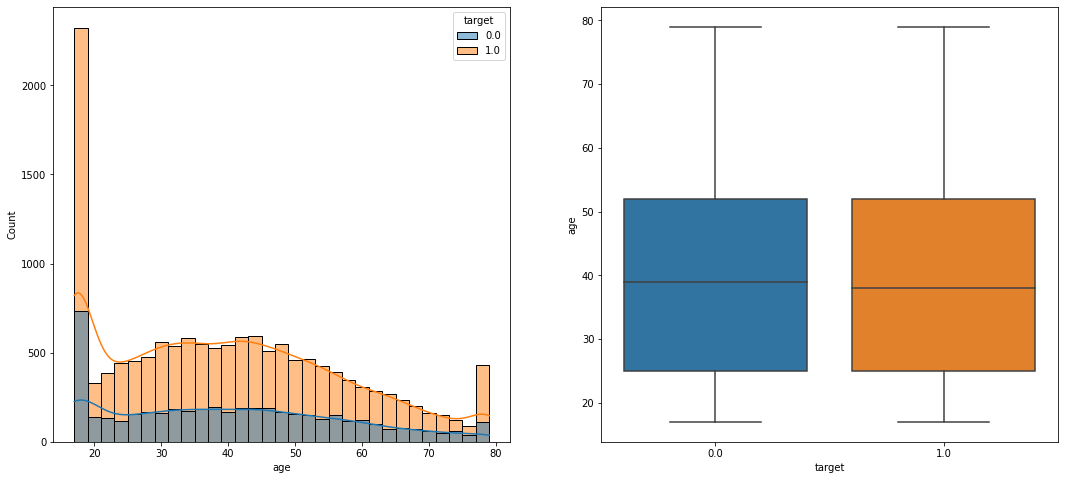

In [227]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="age", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="age", data=dados_limpos, ax=axes[1])

Percebemos que a faixa etária provável para comprar novamente é a mesma para não comprar (1º gráfico), logo, não é a idade que influência na compra. Podemos comprovar isso com o 2º gráfico, que é possível perceber a mesma distribuição no 2º gráfico.

##Salário:

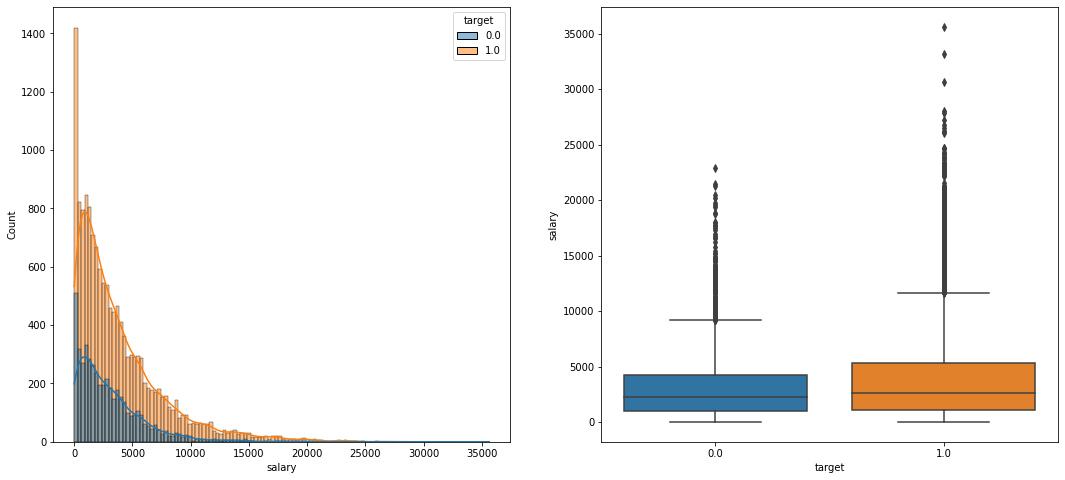

In [228]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="salary", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="salary", data=dados_limpos, ax=axes[1])

Aqui, é possível perceber que a probabilidade de um usuário comprar novamente pelo aplicativo aumenta conforme o salário do mesmo for maior, como é possível perceber no 2º gráfico, onde o final do "1" é mais espesso que o "0".

##Credit Score:

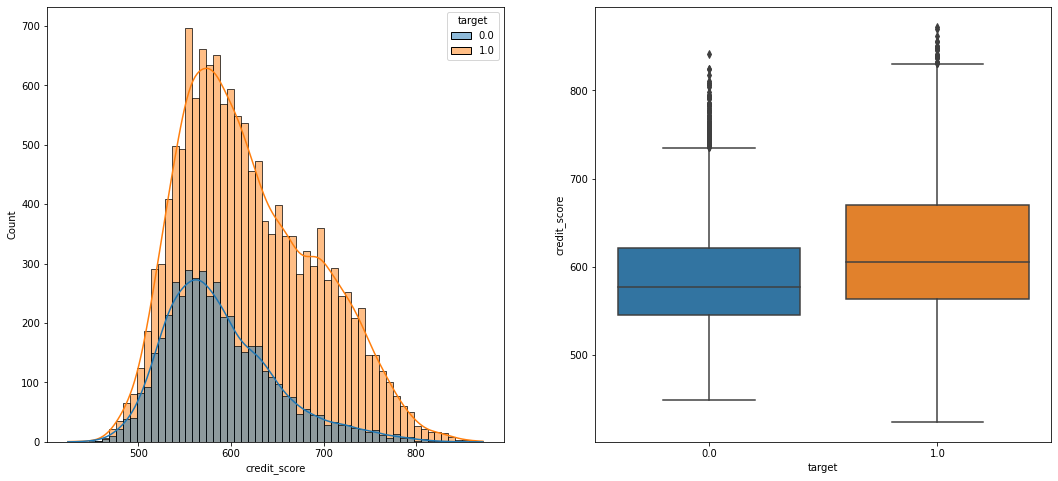

In [229]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="credit_score", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="credit_score", data=dados_limpos, ax=axes[1])

Temos um comportamento parecido com o salário, ou seja, quando mais credit score o usuário tiver, mais chance ele tem de comprar novamente no aplicativo. 

##Acesso - 2 semanas atrás:

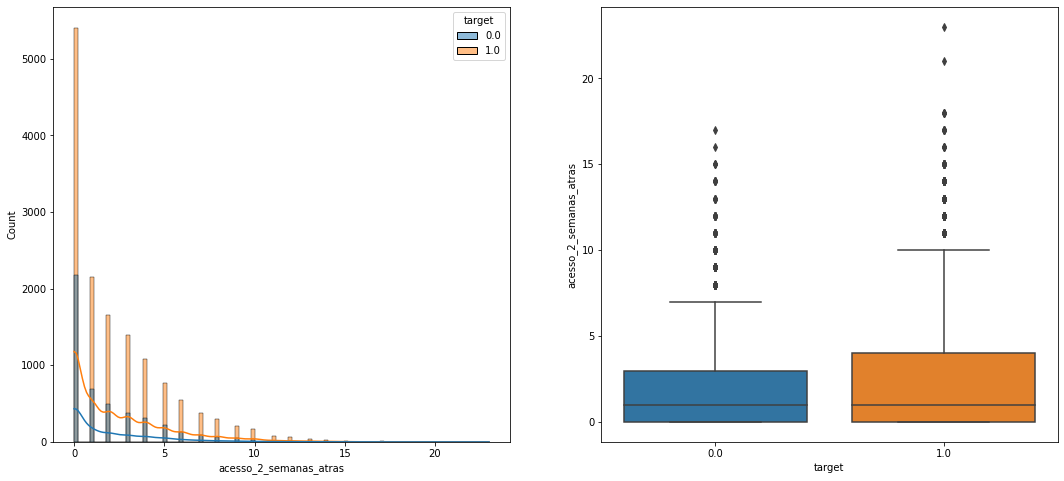

In [230]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="acesso_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="acesso_2_semanas_atras", data=dados_limpos, ax=axes[1])

Esse gráfico comprova que, quanto mais acessos o usuário realizar no aplicativo, mais provável do mesmo realizar uma compra.

##Pesquisa Mercado - 2 semanas atrás:

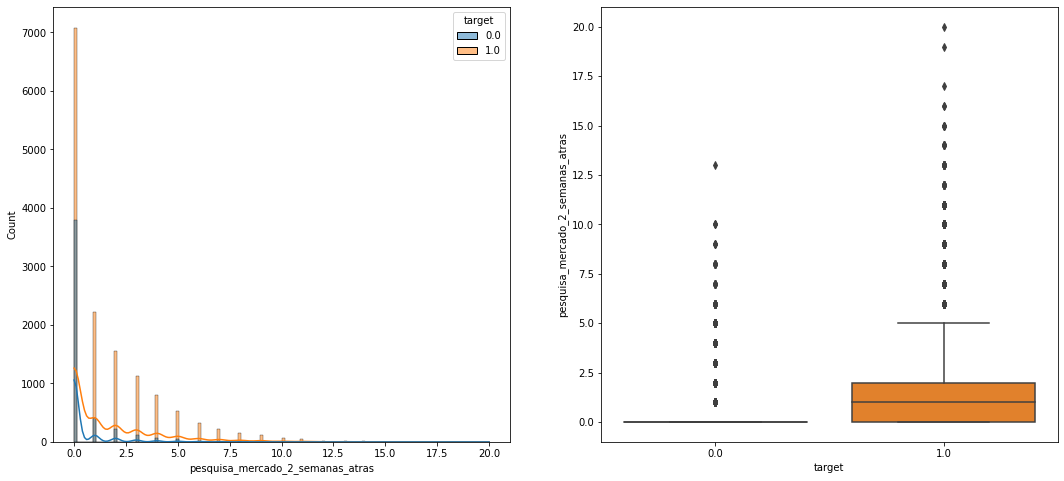

In [231]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_mercado_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_mercado_2_semanas_atras", data=dados_limpos, ax=axes[1])

Dos usuários que compraram na última semana, tivemos muitas pesquisas em mercados.

##Pesquisa Restaurante - 2 semanas atrás:

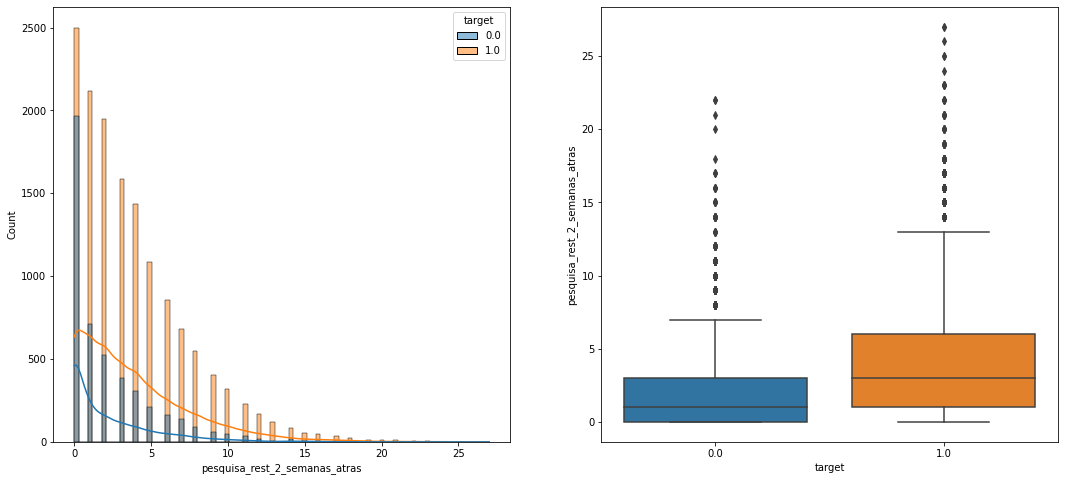

In [232]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_rest_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_rest_2_semanas_atras", data=dados_limpos, ax=axes[1])

A probabilidade de um usuário comprar cresce conforme mais pesquisas sobre restaurante são realizadas.

##Pesquisa Restaurante - 3 semanas atrás:

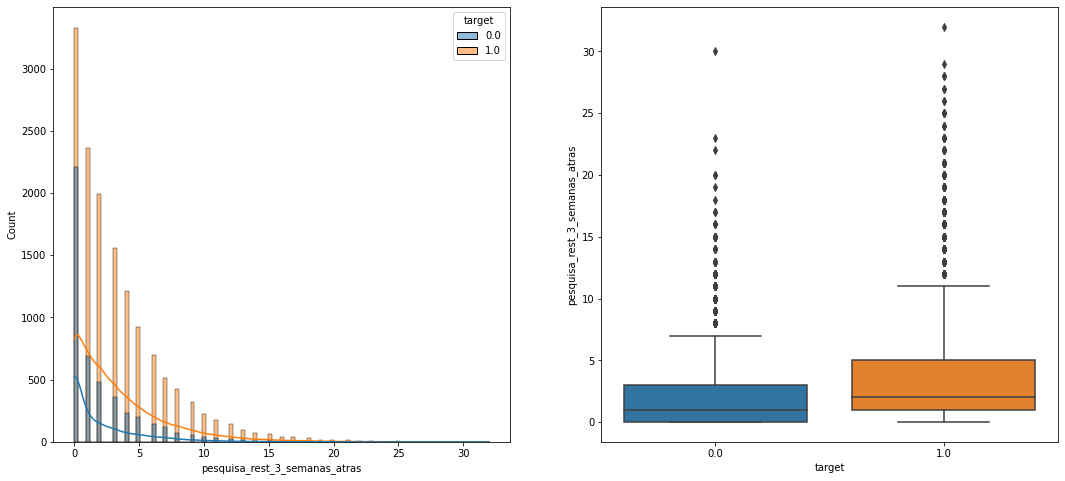

In [233]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_rest_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_rest_3_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso público-alvo realizou muitas pesquisas sobre restaurante a 3 semanas atrás, quando comparado com os usuários que não compraram na última semana.

##Pesquisa Farmácia - 2 semanas atrás:

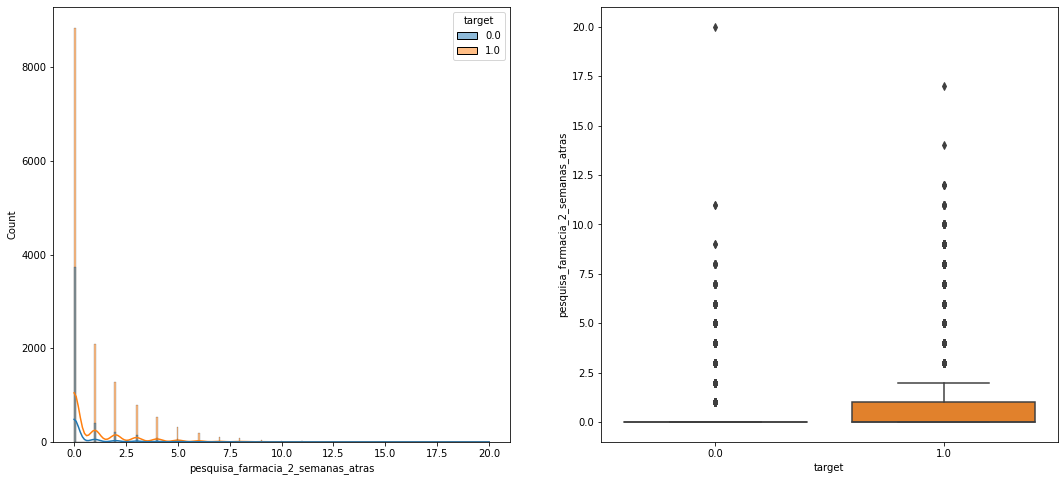

In [234]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_farmacia_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_farmacia_2_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso público-alvo possui uma tendência muito grande de realizar pesquisas sobre farmácia.


##Pesquisa Farmácia - 3 semanas atrás:

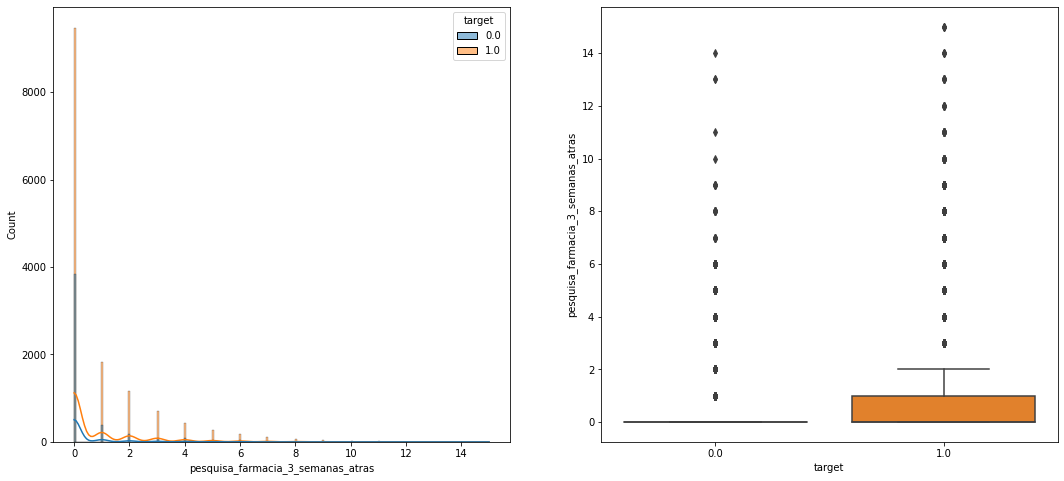

In [235]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_farmacia_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_farmacia_3_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso público-alvo possui uma tendência muito grande de realizar pesquisas sobre farmácia.

##Pesquisa PET - 2 semanas atrás:

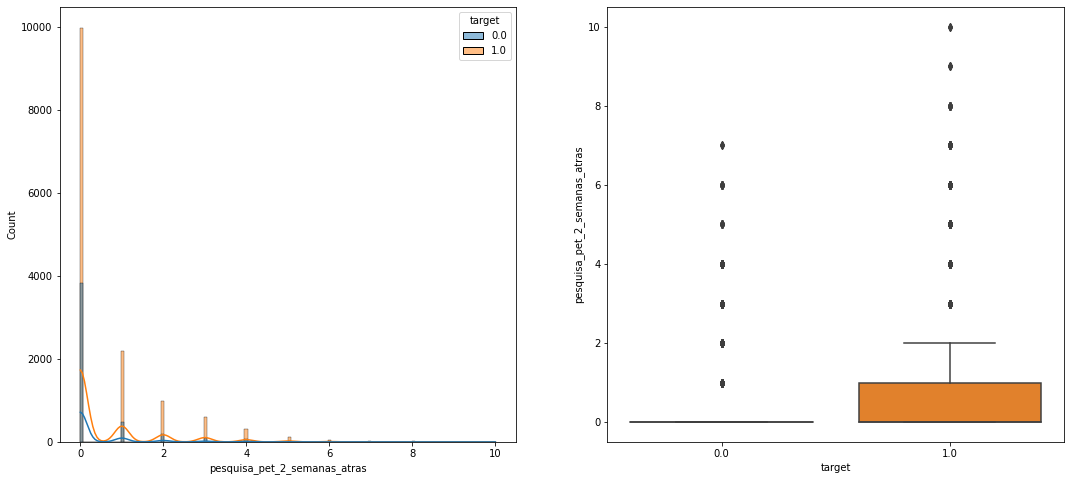

In [236]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_pet_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_pet_2_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso público-alvo possui uma tendência muito grande de realizar pesquisas sobre petshop.

##Pesquisa PET - 3 semanas atrás:

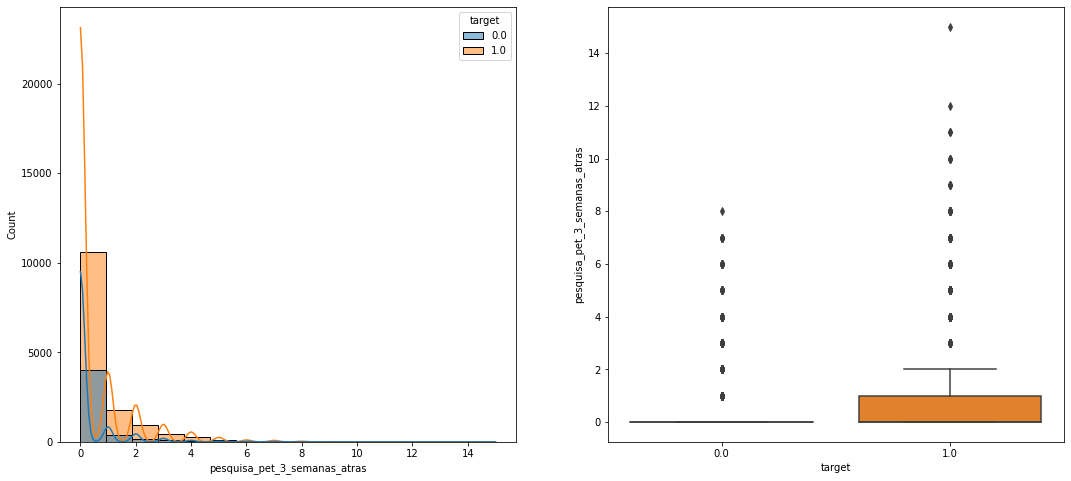

In [237]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="pesquisa_pet_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="pesquisa_pet_3_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso público-alvo possui uma tendência muito grande de realizar pesquisas sobre petshop.

##Total de Itens (Mercado) adicionado ao Carrinho - 2 semanas atrás:

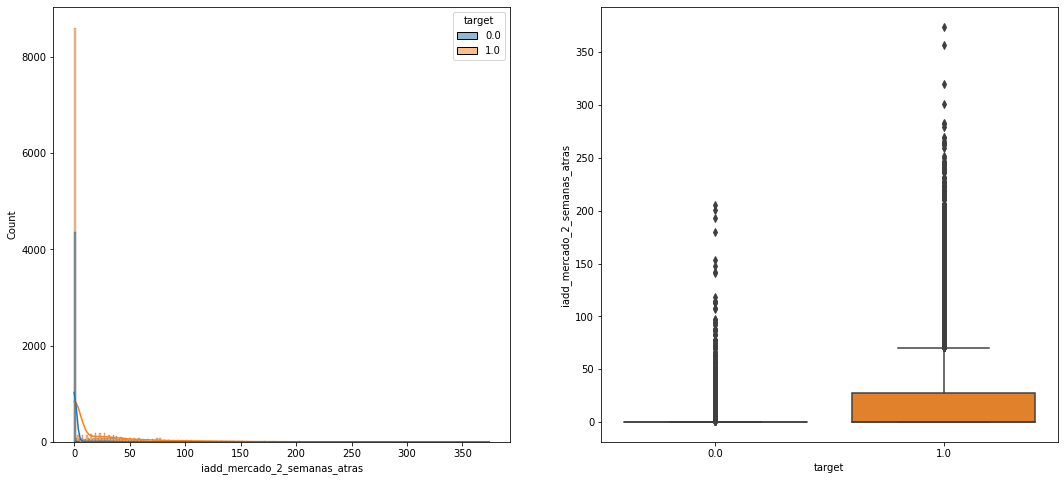

In [238]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_mercado_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_mercado_2_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona mais itens de mercado no carrinho do que aqueles que não compraram na última semana.


##Total de Itens (Mercado) adicionado ao Carrinho - 3 semanas atrás:

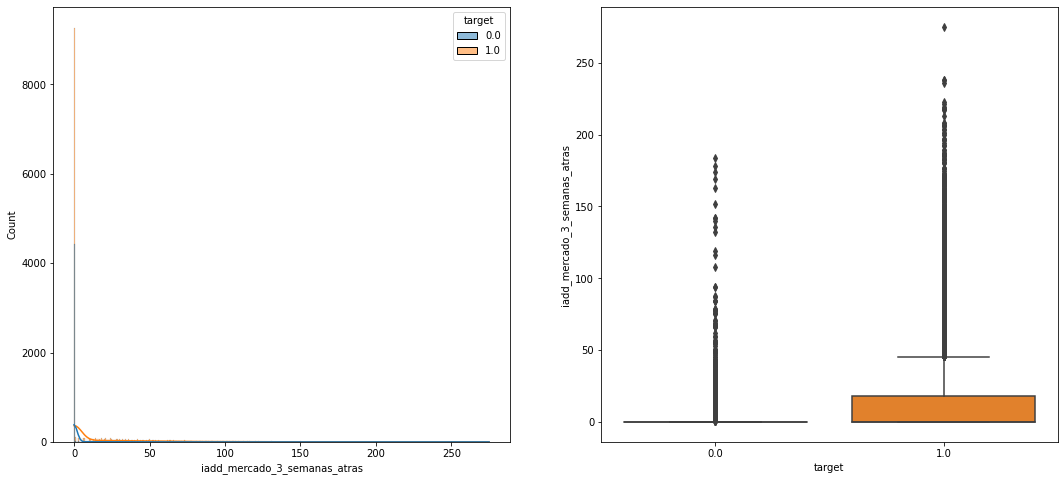

In [239]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_mercado_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_mercado_3_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona mais itens de mercado no carrinho do que aqueles que não compraram na última semana.

##Total de Itens (Restaurante) adicionado ao Carrinho - 2 semanas atrás:

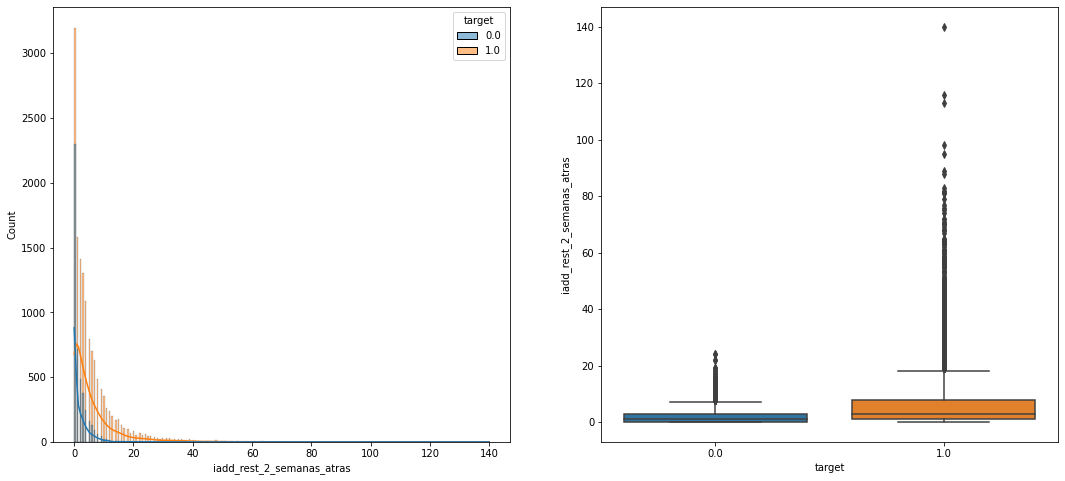

In [240]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_rest_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_rest_2_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona mais itens de restaurante no carrinho do que aqueles que não compraram na última semana.

##Total de Itens (Restaurante) adicionado ao Carrinho - 3 semanas atrás:

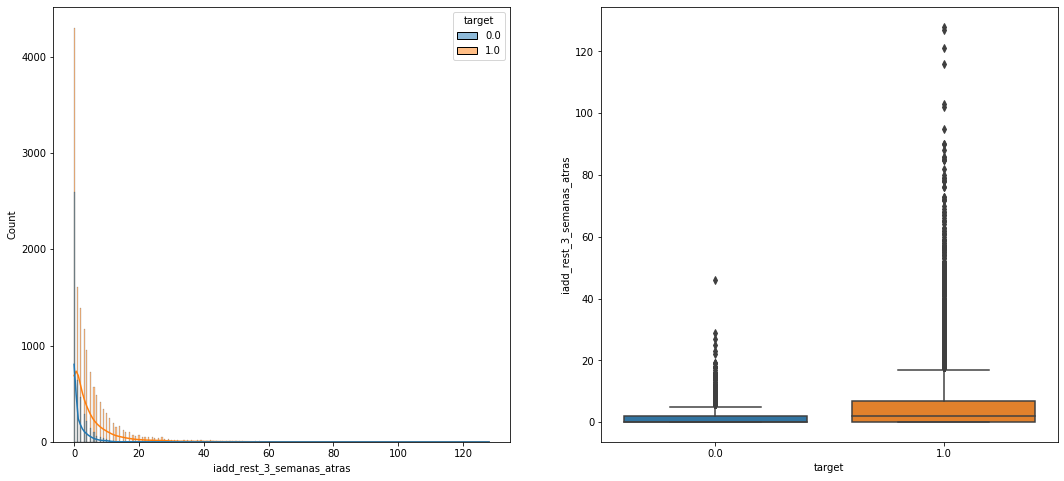

In [241]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_rest_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_rest_3_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona mais itens de restaurante no carrinho do que aqueles que não compraram na última semana.

##Total de Itens (Farmácia) adicionado ao Carrinho - 2 semanas atrás:

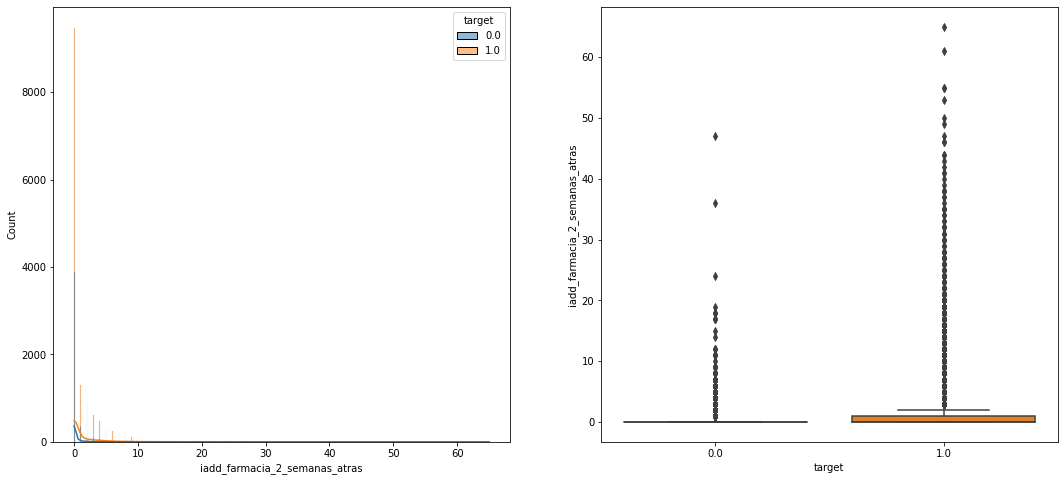

In [242]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_farmacia_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_farmacia_2_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona itens de farmácia no carrinho, ao contrário daqueles que não compraram na última semana.

##Total de Itens (Farmácia) adicionado ao Carrinho - 3 semanas atrás:

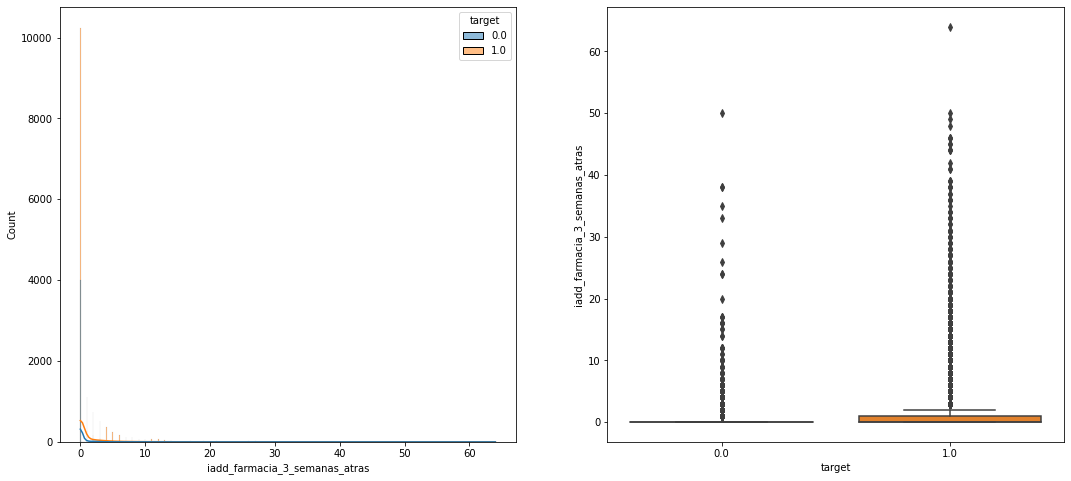

In [243]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_farmacia_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_farmacia_3_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona itens de farmácia no carrinho, ao contrário daqueles que não compraram na última semana.

##Total de Itens (Petshop) adicionado ao Carrinho - 2 semanas atrás:

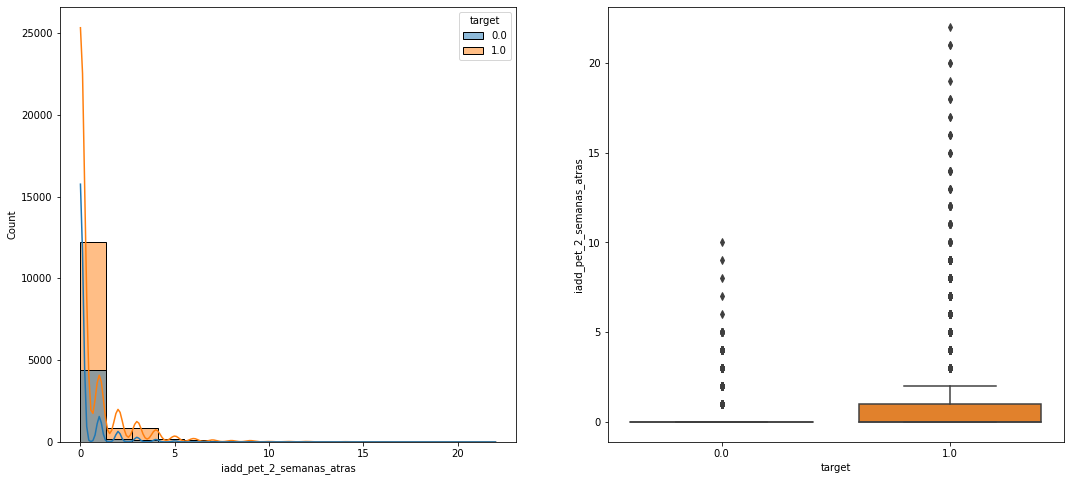

In [244]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_pet_2_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_pet_2_semanas_atras", data=dados_limpos, ax=axes[1])

Nosso públic-alvo adiciona itens de farmácia no carrinho, ao contrário daqueles que não compraram na última semana.

##Total de Itens (Petshop) adicionado ao Carrinho - 3 semanas atrás:

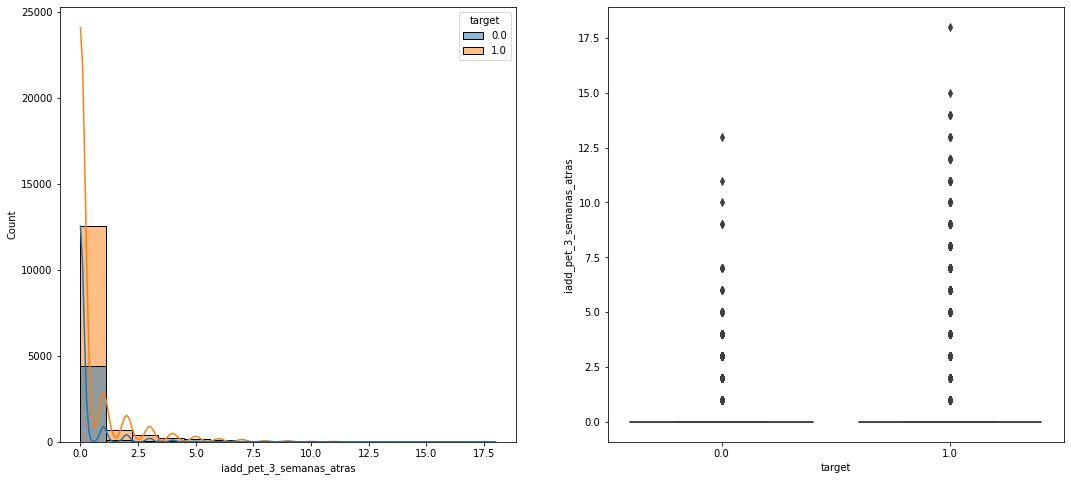

In [245]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="iadd_pet_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="iadd_pet_3_semanas_atras", data=dados_limpos, ax=axes[1])

Não houve diferença entre os usuários que compraram e os que não compraram.

##Média do Total de Itens no Aplicativo:

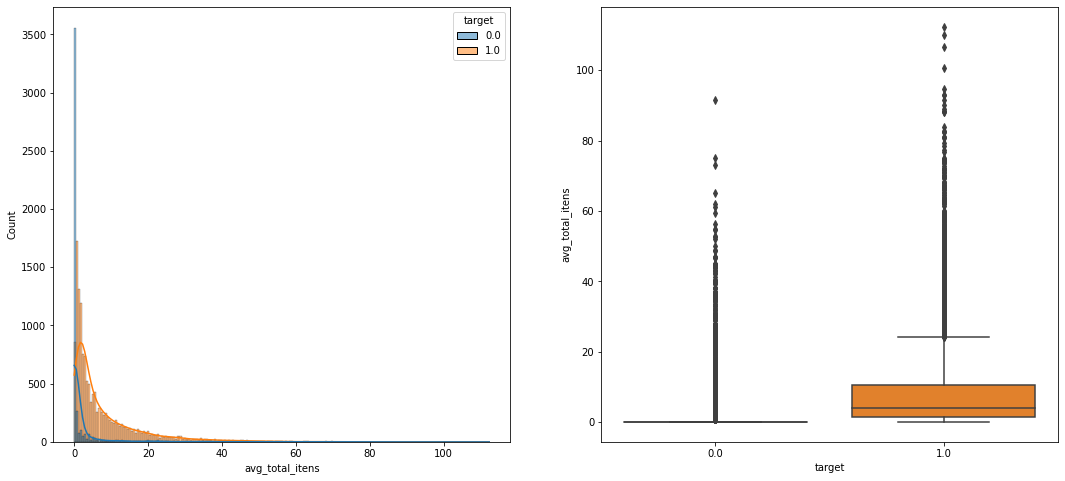

In [246]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="avg_total_itens", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="avg_total_itens", data=dados_limpos, ax=axes[1])

Podemos perceber que o nosso público-alvo tem uma tendência maior de comprar mais itens.

##Média do Total de Itens no Aplicativo - 3 semanas atrás:

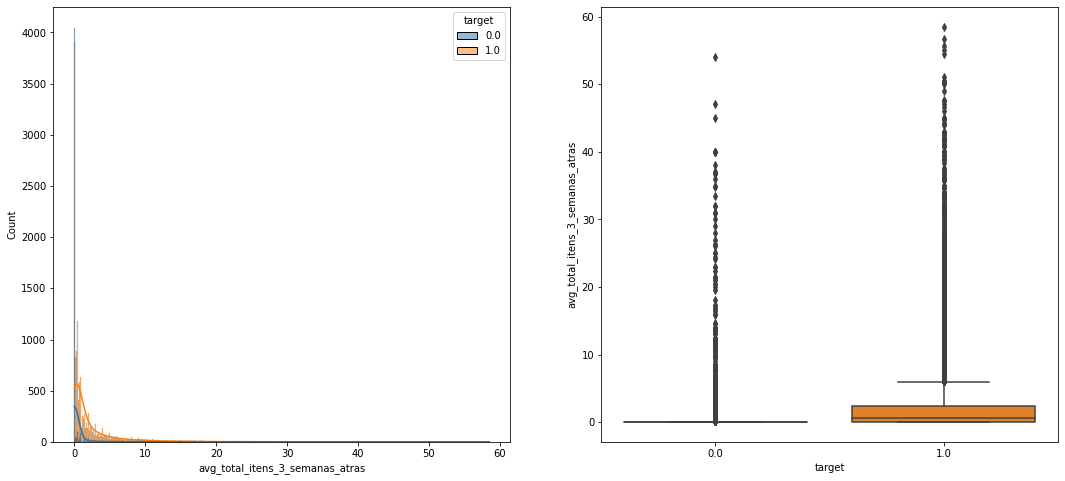

In [247]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="avg_total_itens_3_semanas_atras", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="avg_total_itens_3_semanas_atras", data=dados_limpos, ax=axes[1])

O comportamento do item anterior prevalece aqui também, mesmo que o nosso público-alvo tenha realizado as compras a 3 semanas atrás.

##Porcentagem de Pagamento no Cartão:

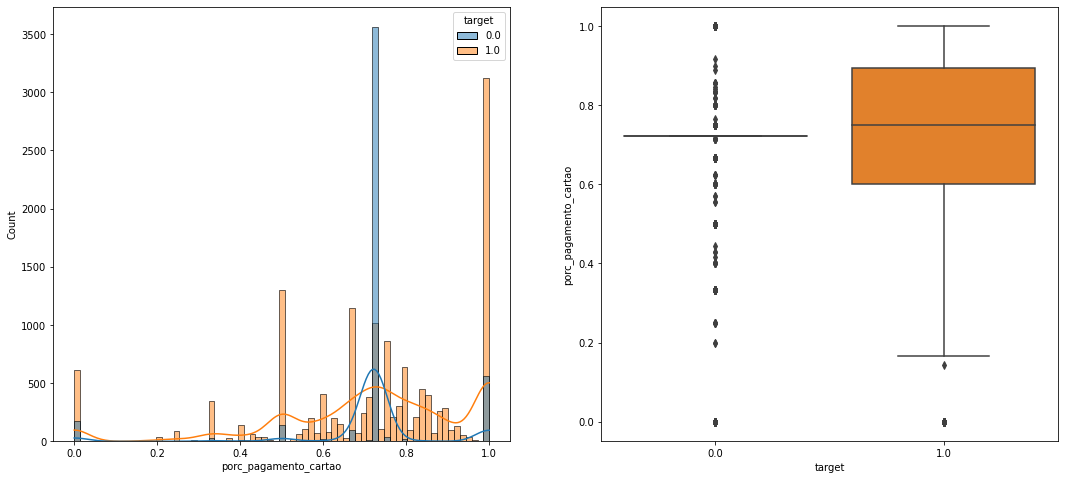

In [248]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="porc_pagamento_cartao", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="porc_pagamento_cartao", data=dados_limpos, ax=axes[1])

Nosso público-alvo faz muitas compras utilizando o cartão de crédito.

##Sitema Android:

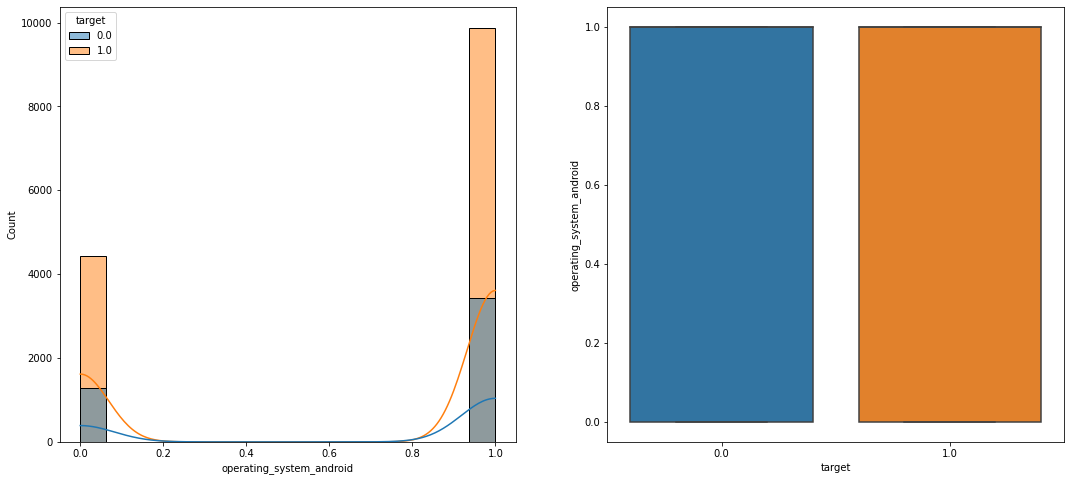

In [249]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(data=dados_limpos, x="operating_system_android", hue="target", kde = True, ax=axes[0])
sns.boxplot(x="target", y="operating_system_android", data=dados_limpos, ax=axes[1])

Podemos perceber que o tipo de sistema do celular não influência na hora de comprar no aplicativo.

## Relação Salário x Média do Total de Itens no Aplicativo - 3 semanas atrás:

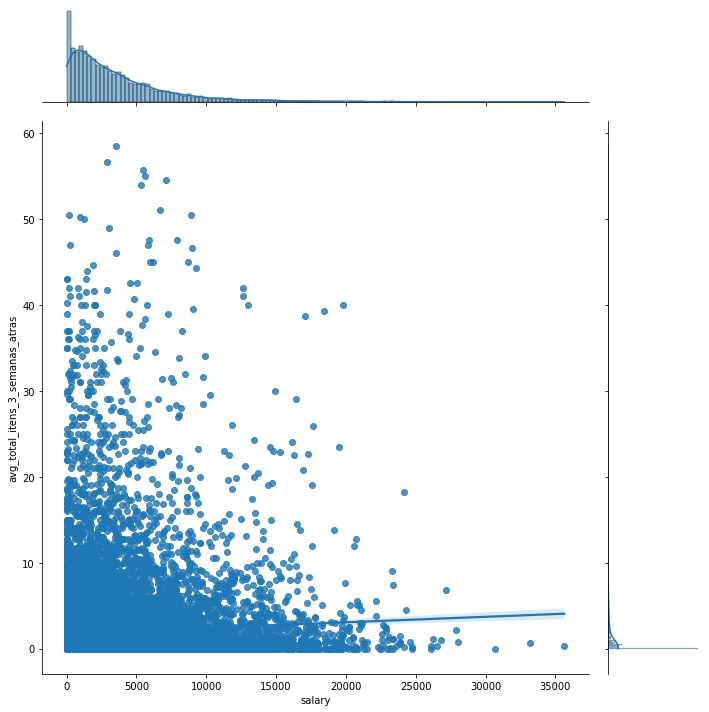

In [250]:
sns.jointplot(data=dados_limpos, x="salary", y="avg_total_itens_3_semanas_atras", kind="reg", height=10)

Podemos perceber que há uma relação proporcional entre as 2 variáveis.

##Relação Idade x Média do Total de Itens no Aplicativo - 3 semanas atrás:

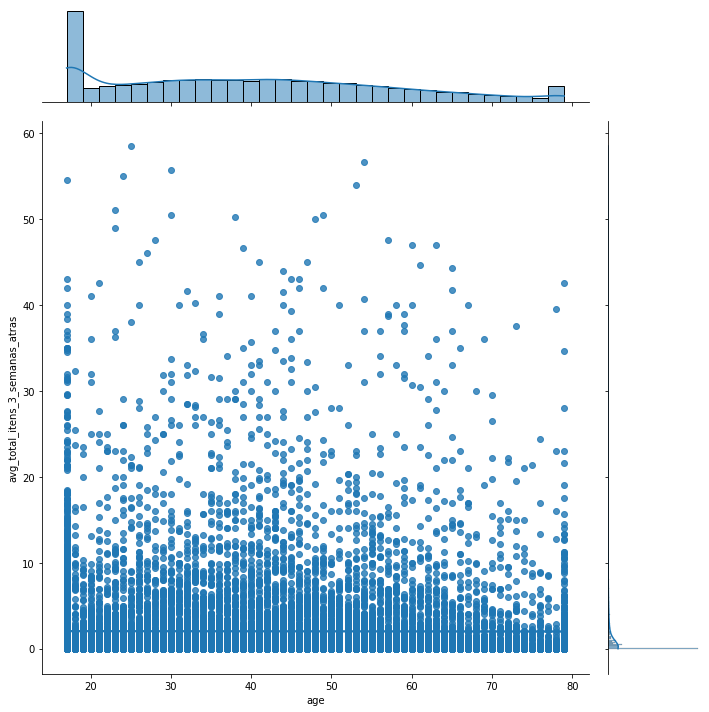

In [251]:
sns.jointplot(data=dados_limpos, x="age", y="avg_total_itens_3_semanas_atras", kind="reg", height=10)

Podemos perceber que não existe uma relação entre as variáveis.

##Relação Credit Score x Média do Total de Itens no Aplicativo - 3 semanas atrás:

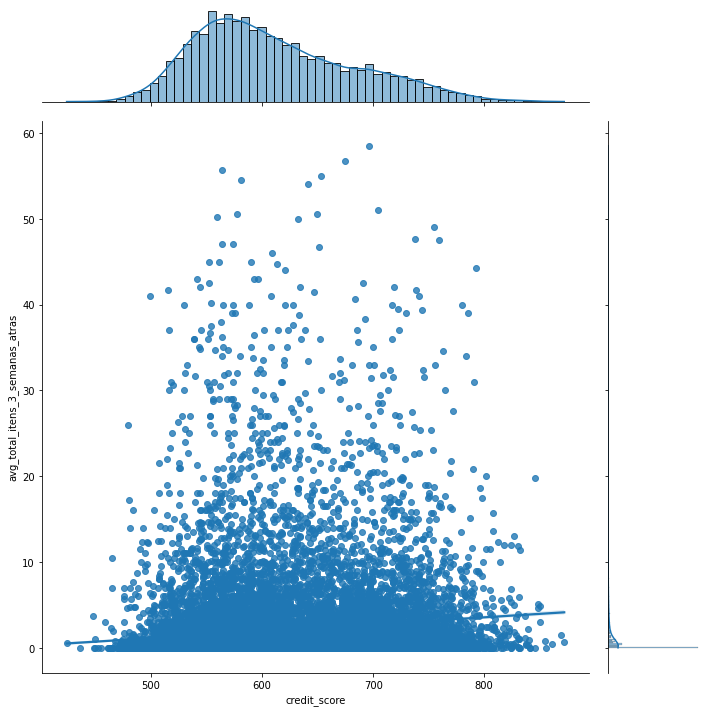

In [252]:
sns.jointplot(data=dados_limpos, x="credit_score", y="avg_total_itens_3_semanas_atras", kind="reg", height=10)

Podemos perceber que existe uma relação proporcional entre as 2 variáveis.

##Pairplot

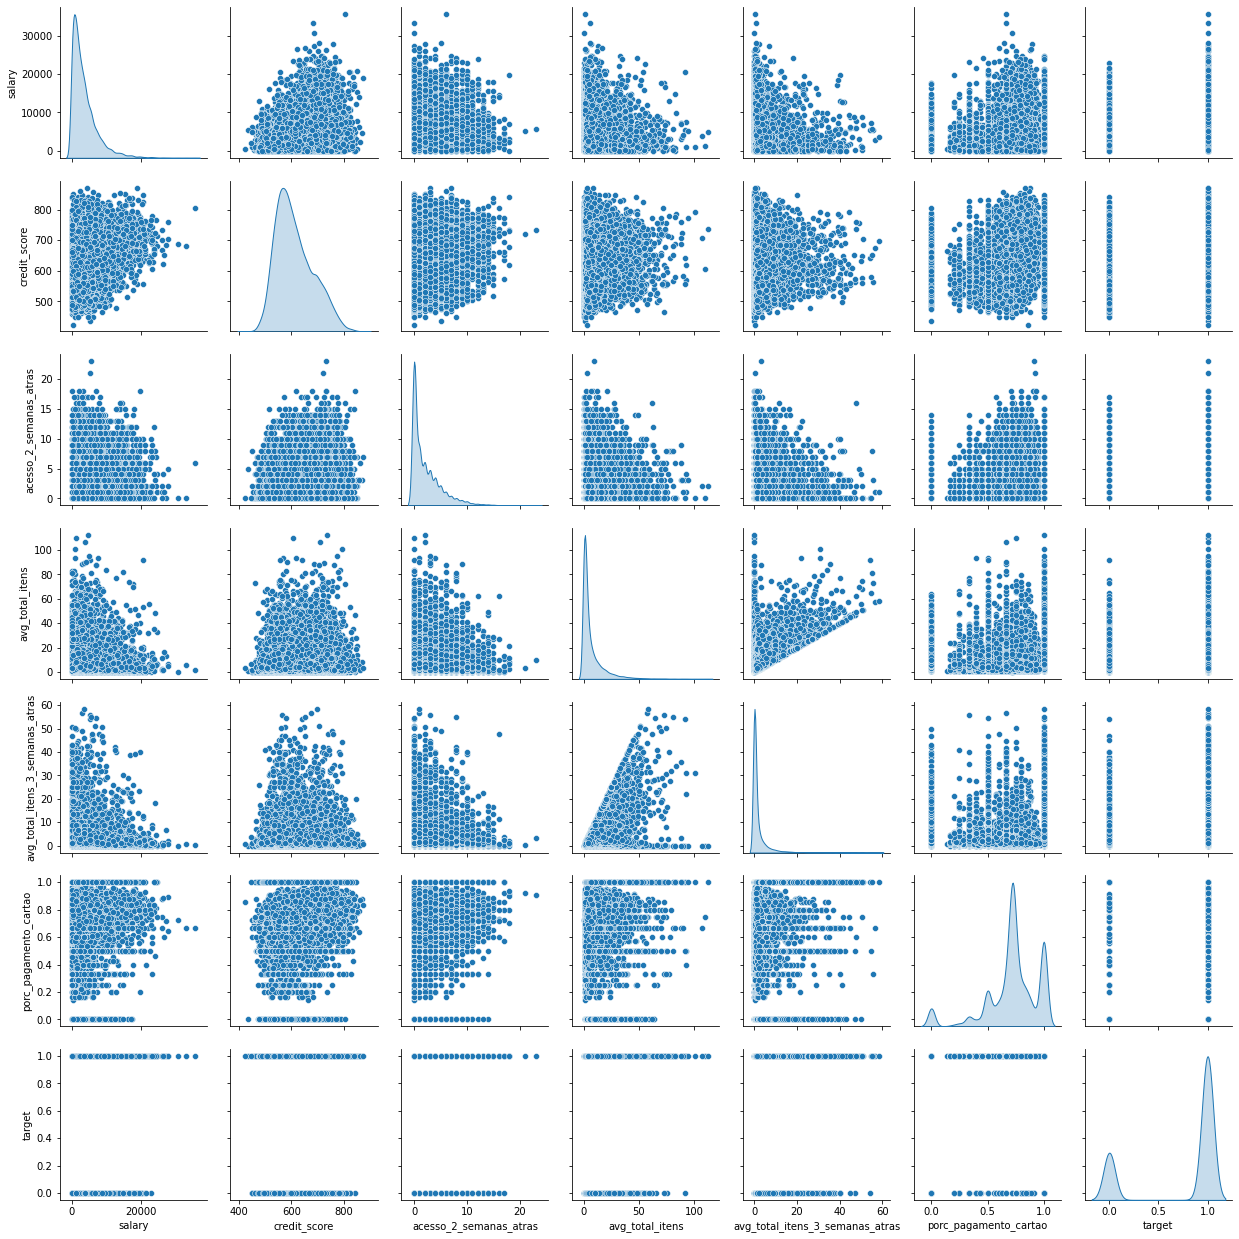

In [253]:
sns.pairplot(dados_limpos,
             x_vars=["salary", "credit_score", "acesso_2_semanas_atras", "avg_total_itens", "avg_total_itens_3_semanas_atras", "porc_pagamento_cartao", "target"],
             y_vars=["salary", "credit_score", "acesso_2_semanas_atras", "avg_total_itens", "avg_total_itens_3_semanas_atras", "porc_pagamento_cartao", "target"],
             diag_kind="kde")

# Machine Learning

##Modelos escolhidos:

Os modelos escolhidos são referentes aos algoritmos de classificação, pois nosso objetivo é determinar se um usuário possui características daquele que comprou na última semana no app ou não. Sendo assim, os modelos escolhidos foram:

1.   Regressão Logística - é um classificador binário, que ajusta uma equação com múltiplas variáveis a partir de uma combinação linear com as variáveis utilizadas no Machine Learning, e a resposta varia entre 0 e 1; o treinamento do modelo serve para encontrar os melhores parâmetros que se adequam aos dados;
2.   Árvore de Decisão - esse modelo se aproxima ao processo de tomada de decisão natural do ser humano: se o tempo estiver chuvoso, fico em casa e assisto um filme, se estiver ensolarado, vou caminhar no parque, e por aí vai; uma analogia para isso seria a árvore de decisão, com as variáveis (clima, por exemplo) e a quantidade de classes (assistir filme e correr no parque, por exemplo);
3.   SVM - *Support Vector Machine* (Máquina de Vetores Suporte), outro modelo de classificação binária, que traça uma linha que divide o cojunto de dados em duas classes (o hiperplano ideal), utilizando os vetores de suporte, que é o nome dado para o ponto mais próximo do hiperplano de cada classe, até encontrar o hiperplano ideal que consegue determinar vetores iguais (ou aproximadamente iguais) entre as classes.

Referência:

https://awari.com.br/algoritmos-de-classificacao/



##Treinando e Avaliando os Modelos:

Para treinar os modelos, vamos utilizar todos os parâmetros que temos, exceto o user_id e o nosso target, já que esse último será o parâmetro que queremos saber o resultado a partir de determinados dados.

In [254]:
X = dados_limpos.drop(['user_id', 'target'], axis=1)
y = dados_limpos['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

##Regressão Logística:

Primeiramente, vamos treinar o modelo!

Uma observação: o modelo de regressão logística precisa que os dados estejam na mesma escala (normalização das variáveis), e para isso, utilizamos a técnica StandardScaler.

Referência:

https://medium.com/ipnet-growth-partner/padronizacao-normalizacao-dados-machine-learning-f8f29246c12

In [255]:
lr = LogisticRegression(random_state=42)

In [256]:
scaler = StandardScaler()

In [257]:
X_train_scl = scaler.fit_transform(X_train)

In [258]:
lr.fit(X_train_scl, y_train)

LogisticRegression(random_state=42)

Agora, vamos avaliar o modelo:

In [259]:
y_pred = lr.predict(scaler.transform(X_test))
y_pred_prob = lr.predict_proba(scaler.transform(X_test))[:,1]

Para a realização do código acima, utilizei a seguinte referência.

https://estatsite.com.br/2020/09/23/regressao-logistica-em-python/

In [260]:
acuracia = accuracy_score(y_test, y_pred)
print('Acurácia:', acuracia*100, '%')

Acurácia: 81.76842105263158 %


In [261]:
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC:', auc)

AUC: 0.8449462841975133


In [262]:
a = pd.DataFrame({'y_test': y_test, 'y_predicted': y_pred_prob})
rvs1 = a.loc[a.y_test==1, 'y_predicted']
rvs2 = a.loc[a.y_test==0, 'y_predicted']
teste = stats.ks_2samp(rvs1, rvs2)
print('Resultado KS:', teste)

Resultado KS: KstestResult(statistic=0.5171048024036201, pvalue=3.4416913763379853e-15)


In [263]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 612,  536],
       [ 330, 3272]])

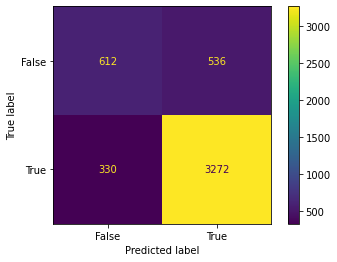

In [264]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Para a realização da matriz de confusão, utilizei a referência a seguir.

https://www.w3schools.com/python/python_ml_confusion_matrix.asp

In [265]:
pr = classification_report(y_test, y_pred)
print(pr)

              precision    recall  f1-score   support

         0.0       0.65      0.53      0.59      1148
         1.0       0.86      0.91      0.88      3602

    accuracy                           0.82      4750
   macro avg       0.75      0.72      0.73      4750
weighted avg       0.81      0.82      0.81      4750



##Árvore de Decisão:

Vamos treinar o modelo primeiramente!

In [266]:
dt = DecisionTreeClassifier(random_state=42)

In [267]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Agora, vamos avaliar o modelo!

In [268]:
y_pred = dt.predict(X_test)
y_pred_prob = dt.predict_proba(X_test)[:,1]

In [269]:
acuracia = accuracy_score(y_test, y_pred)
print('Acurácia:', acuracia*100, '%')

Acurácia: 83.38947368421053 %


In [270]:
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC:', auc)

AUC: 0.7812814986641181


In [271]:
a = pd.DataFrame({'y_test': y_test, 'y_predicted': y_pred_prob})
rvs1 = a.loc[a.y_test==1, 'y_predicted']
rvs2 = a.loc[a.y_test==0, 'y_predicted']
teste = stats.ks_2samp(rvs1, rvs2)
print('Resultado KS:', teste)

Resultado KS: KstestResult(statistic=0.5625629973282361, pvalue=3.4416913763379853e-15)


In [274]:
cm1 = confusion_matrix(y_test, y_pred)
cm1

array([[ 780,  368],
       [ 421, 3181]])

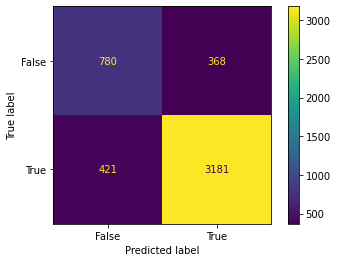

In [275]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [276]:
pr = classification_report(y_test, y_pred)
print(pr)

              precision    recall  f1-score   support

         0.0       0.65      0.68      0.66      1148
         1.0       0.90      0.88      0.89      3602

    accuracy                           0.83      4750
   macro avg       0.77      0.78      0.78      4750
weighted avg       0.84      0.83      0.84      4750



##Support Vector Machine (SVM):

Treinando o nosso modelo, que precisa passar pela normalização das variáveis!

In [277]:
svm = SVC(kernel='linear', probability=True, random_state=42)

In [278]:
scaler = StandardScaler()

In [279]:
X_train_scl = scaler.fit_transform(X_train)

In [280]:
svm.fit(X_train_scl, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Agora, vamos analisar nosso modelo!

Referência:

https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

In [281]:
y_pred = svm.predict(scaler.transform(X_test))
y_pred_prob = svm.predict_proba(scaler.transform(X_test))[:,1]

In [282]:
acuracia = accuracy_score(y_test, y_pred)
print('Acurácia:', acuracia*100, '%')

Acurácia: 81.17894736842105 %


In [283]:
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC:', auc)

AUC: 0.8443924881066849


In [284]:
a = pd.DataFrame({'y_test': y_test, 'y_predicted': y_pred_prob})
rvs1 = a.loc[a.y_test==1, 'y_predicted']
rvs2 = a.loc[a.y_test==0, 'y_predicted']
teste = stats.ks_2samp(rvs1, rvs2)
print('Resultado KS:', teste)

Resultado KS: KstestResult(statistic=0.5194679881676266, pvalue=3.4416913763379853e-15)


In [287]:
cm2 = confusion_matrix(y_test, y_pred)
cm2

array([[ 678,  470],
       [ 424, 3178]])

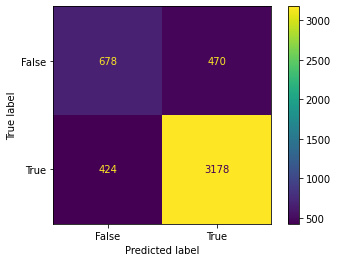

In [288]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [289]:
pr = classification_report(y_test, y_pred)
print(pr)

              precision    recall  f1-score   support

         0.0       0.62      0.59      0.60      1148
         1.0       0.87      0.88      0.88      3602

    accuracy                           0.81      4750
   macro avg       0.74      0.74      0.74      4750
weighted avg       0.81      0.81      0.81      4750



##Qual modelo escolher?

Para a escolha do modelo, utilizamos a métrica "precision" como a métrica determinante, pelo motivo de que considero o "falso positivo" (aquele que tem é considerado possível comprador, mas não é) mais importante para levar em consideração do que o "falso negativo" (aquele que não é considerado um possível comprador, mas é), já que quando temos um possível comprador, mas não é, seria um alarme falso de que houve uma compra no app, prejudicando na projeção da receita. Com isso, temos que: 

Métrica: Precision

Modelo que melhor que se adapta a métrica: **Árvore de Decisão**

Referência:

https://vitorborbarodrigues.medium.com/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c

##Calibração dos Hiperparâmetros:

Com o modelo definido ("Árvore de Decisão"), vamos calibrar nossos hiperparâmetros a seguir.

Referências:

https://www.projectpro.io/recipes/tune-hyper-parameters-using-random-search-in-python

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/

In [290]:
parameters = {'max_depth' : np.linspace(1, 20, 20, endpoint=True),
              'min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10],
              'min_weight_fraction_leaf' : np.linspace(0.1, 0.9, 9, endpoint=True),
              'max_features' : ["auto","log2","sqrt",None],
              'max_leaf_nodes': [None,10,20,30,40,50,60,70,80,90]
              }

In [291]:
clf = RandomizedSearchCV(dt, parameters, random_state=42, n_iter=100, cv=5, verbose=0, n_jobs=-1)
search = clf.fit(X_train, y_train)
search.best_params_


215 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
215 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 304, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_leaf must in [0, 0.5]

One or more of the test scores are non-finite: [0.7474386         nan 0.75066667 0

{'min_weight_fraction_leaf': 0.2,
 'min_samples_leaf': 3,
 'max_leaf_nodes': 50,
 'max_features': None,
 'max_depth': 19.0}

Agora que encontramos o melhor valor para os nossos hiperparâmetros, vamos treinar novamente nosso modelo.

In [292]:
dt_cal = DecisionTreeClassifier(random_state=42,
                                max_depth = 19,
                                min_samples_leaf = 3,
                                min_weight_fraction_leaf = 0.2,
                                max_features = None,
                                max_leaf_nodes = 50
                                )

In [293]:
dt_cal.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=19, max_leaf_nodes=50, min_samples_leaf=3,
                       min_weight_fraction_leaf=0.2, random_state=42)

E, por fim, avaliando nosso modelo, temos que:

In [294]:
y_pred = dt_cal.predict(X_test)
y_pred_prob = dt_cal.predict_proba(X_test)[:,1]

In [295]:
acuracia = accuracy_score(y_test, y_pred)
print('Acurácia:', acuracia*100, '%')

Acurácia: 89.57894736842105 %


In [296]:
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC:', auc)

AUC: 0.8902200819521482


In [297]:
a = pd.DataFrame({'y_test': y_test, 'y_predicted': y_pred_prob})
rvs1 = a.loc[a.y_test==1, 'y_predicted']
rvs2 = a.loc[a.y_test==0, 'y_predicted']
teste = stats.ks_2samp(rvs1, rvs2)
print('Resultado KS:', teste)

Resultado KS: KstestResult(statistic=0.7041234351028368, pvalue=3.4416913763379853e-15)


In [300]:
cm3 = confusion_matrix(y_test, y_pred)
cm3

array([[ 881,  267],
       [ 228, 3374]])

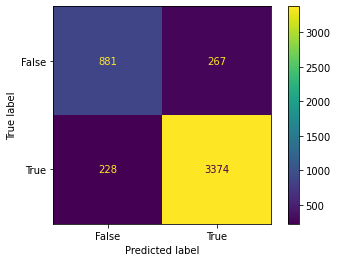

In [301]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [302]:
pr = classification_report(y_test, y_pred)
print(pr)

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      1148
         1.0       0.93      0.94      0.93      3602

    accuracy                           0.90      4750
   macro avg       0.86      0.85      0.86      4750
weighted avg       0.89      0.90      0.90      4750



#Interpretando os Modelos

Relacionando os coeficientes com as nossas variáveis para o modelo de Regressão Logística.

In [303]:
coefs = pd.DataFrame(
    lr.coef_[0],
    columns=['Coefficients'], index=X_train.columns.tolist()
)
df_coef = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=False).index)

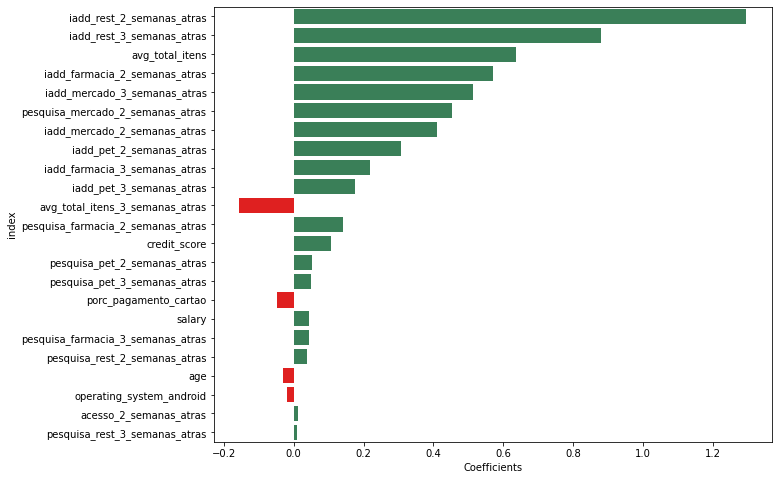

In [304]:
plt.figure(figsize=(10, 8))
sns.barplot(x="Coefficients", y="index", data=df_coef.reset_index(),
            label="coefs", palette=["seagreen" if x>=0 else 'r' for x in df_coef["Coefficients"]])
plt.show()

Agora, para visualizar a importância das variáveis para o modelo "Árvore de Decisão", que aqui, vamos utilizar o modelo XGBoost, junto com a ferramenta SHAP.

Referência:

https://github.com/slundberg/shap

Treinando nosso modelo!

In [305]:
xgb = XGBClassifier(random_state=42)

In [306]:
xgb.fit(X_train, y_train)

XGBClassifier(random_state=42)

Vamos avaliar nosso modelo!

In [307]:
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)[:,1]

In [308]:
acuracia = accuracy_score(y_test, y_pred)
print('Acurácia:', acuracia*100, '%')

Acurácia: 90.25263157894737 %


In [309]:
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC:', auc)

AUC: 0.9276974464438068


In [310]:
a = pd.DataFrame({'y_test': y_test, 'y_predicted': y_pred_prob})
rvs1 = a.loc[a.y_test==1, 'y_predicted']
rvs2 = a.loc[a.y_test==0, 'y_predicted']
teste = stats.ks_2samp(rvs1, rvs2)
print('Resultado KS:', teste)

Resultado KS: KstestResult(statistic=0.725915915857818, pvalue=3.4416913763379853e-15)


In [313]:
cm4 = confusion_matrix(y_test, y_pred)
cm4

array([[ 874,  274],
       [ 189, 3413]])

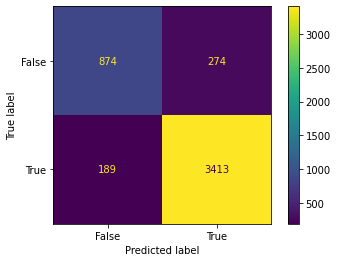

In [314]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [315]:
pr = classification_report(y_test, y_pred)
print(pr)

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79      1148
         1.0       0.93      0.95      0.94      3602

    accuracy                           0.90      4750
   macro avg       0.87      0.85      0.86      4750
weighted avg       0.90      0.90      0.90      4750



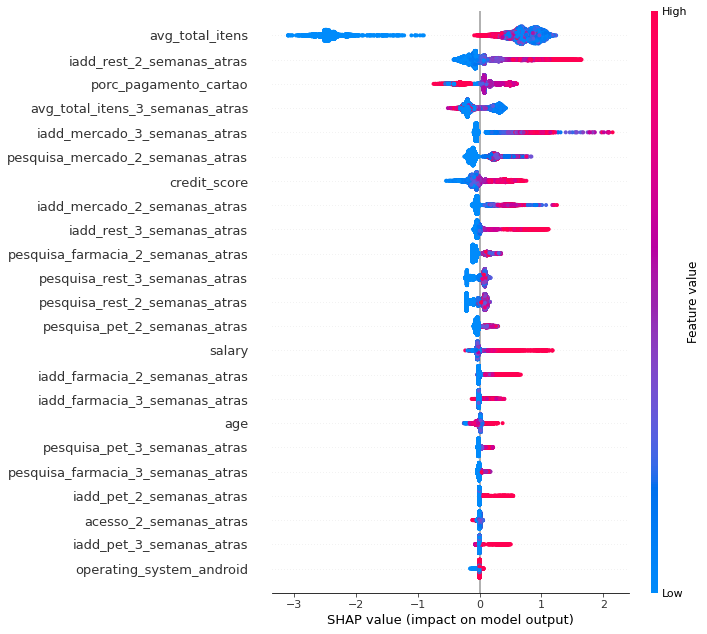

In [316]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=25)

Agora, vamos comparar os 2 gráficos que obtemos.

A primeira coisa que percebemos, as variáveis com mais importância para os 2 modelos são:

*   avg_total_itens
*   iadd_rest_2_semanas_atras

As outras variáveis variam o seu grau de importância, dependendo de cada modelo. Agora, vamos analisar essas 2 variáveis.

Para o modelo de regressão logística, temos o resultado do coeficiente para cada variável, e observando o gráfico, a variável "avg_total_itens" tem o coeficiente igual a 0,62, aproximadamente, enquanto que a variável "iadd_rest_2_semanas_atras" tem o valor 1,3, aproximadamente. Para a interpretação desses coeficientes, vamos utilizar um outro gráfico, referente ao modelo da regressão logística.



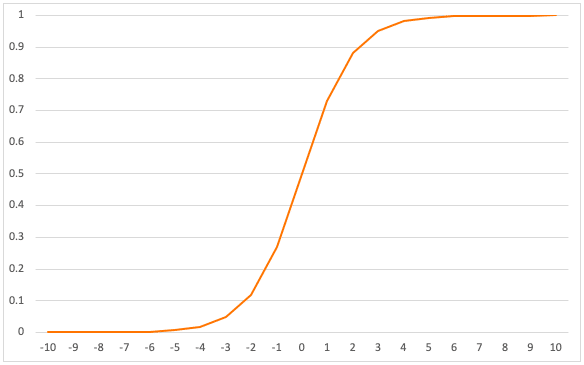

Os valores no eixo x representam o nosso coeficiente, enquanto que no eixo y temos a nossa classificação biário (se for menor que 0,5, o resultado será 0, e no nosso caso, temos um usuário que não faz parte do nosso target, enquanto que se for maior 0,5, o resultado será 1, que fará parte do nosso target, ou seja, que realizou alguma compra na última semana e tem mais probabilidade de realizar uma compra na próxima semana).

Então, analisando o gráfico acima, temos que:

*   avg_total_itens (0,62) = 0,63 (como é maior que 0,5, logo, o resultado é igual a 1)
*   iadd_rest_2_semanas_atras (1,30) = 0,78 (como é maior que 0,5, logo, o resultado é igual a 1)

Isso significa que, se o usuário apresentar essas características, mais provável de realizar uma nova compra na próxima semana.

Agora, vamos analisar o SHAP gerado pelo modelo de XGBoost.

A cor vermelha significa que é mais próvavel de comprar (nosso target igual a 1), enquanto que a cor azul é o contrário (target igual a 0).

Ou seja, quanto maior for a média de itens comprados (até um certo ponto), e mais itens de restaurante adicionado no carrinho a 2 semanas atrás, mais próvavel é do usuário realizar uma nova compra na próxima semana no aplicativo.

Referência:

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html?highlight=beeswarm